# Understanding the Comparison Utility

by Vivian Grom (vgrom1@lsu.edu)

The objective is to perform quantitative and visual assessment of dissimilarity and variability between simulations.

## Metrics:
**Shannon Entropy** (information entropy) – Measurement of uncertainty or information content of a random variable.

**Moran’s I** (spatial autocorrelation) – Index calculated from standardized spatial covariance.

**Geary’s C** (spatial autocorrelation) – Sum of squared distances.

For this example, we will use the following libraries:

In [74]:
#%% Import libraries

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as mpl_cm
from landlab import RasterModelGrid, imshow_grid

## An overview of the metrics, before starting the analysis

### *Shannon Entropy*

Shannon's entropy, named after Claude Shannon, is a concept from information theory that measures the uncertainty or randomness associated with a random variable. It provides a quantitative measure of the average amount of information or surprise associated with an event (Shannon, 1948).

The formula for Shannon's entropy (H) for a discrete random variable X with probability mass function P(X) is given by:

$$ H(X)= - \sum_{i=1}^{N}[P(x_{i}) * log⁡ P(x_{i})]$$

Where:
- xi represents each possible outcome of the random variable.
- P(xi) is the probability of occurrence of xi.
- The logarithm is usually taken to the base 2, so the resulting entropy is measured in bits. If the entropy is being measured between more than 2 models, the base would change for the number of models to be analyzed.

The key idea is that events with lower probabilities contribute more to the entropy, and events with higher probabilities contribute less. If the probability distribution is more spread out, indicating higher uncertainty, the entropy will be higher. Conversely, if the probability distribution is more concentrated, indicating lower uncertainty, the entropy will be lower.

Shannon's entropy has applications in various fields, including information theory, cryptography, data compression, and statistics. It provides a fundamental measure of the average information content or uncertainty associated with a set of possible outcomes in each probability distribution.


**How is the algorithm working?**

From a mathematical perspective, the expression $ H(X)= - \sum_{i=1}^{N}[P(x_{i}) * log⁡ P(x_{i})]$ represents the entropy for a given set of probabilities. To move from this equation to its implementation in code, we need to break down the mathematical operations and apply them element-wise for the entire grid.

Here is the detailed step-by-step breakdown:

*Mathematical Perspective:*
<br>
<br>
- *How is each $P(x_{i,j})$ calculated?:*

To calculate $P(x_{i,j})$ for a set of experiments, first is necessary to calculate the Maximum Modular Difference of all experiments.The code takes a list of `n` matrices, each with dimensions matching the `grid`, and initializes a matrix `R` with zeros to store the maximum differences. For each element $R_{i,j}$ in the grid, compute the maximum absolute difference between consecutive matrices:

$$R_{i,j} = max (|matrices[k][i,j] - matrices[(k+1)n][i,j]|)$$ for k ∈ {0, 1, ...}

The maximum value in `R` is found and assigned to `k`:

$$k = max(R)$$

If there are only two matrices, the code calculates the probability matrix directly:

$$ p_{1}=  \frac{ |matrices[0] - matrices[1]| }{ k * n }$$

$$p_{2} = 1 - p_{1}$$

For more than two matrices, the code calculates the probability for each pair of consecutive matrices:

$$ p_{i,j}=  \frac{ |matrices[i] - matrices[j]| }{ k * n }$$

where $j = (i+1)$%n

In the context of calculating Shannon entropy, having a probability of zero can cause mathematical issues because the logarithm of zero is undefined and results in negative infinity. To avoid these issues, the code replaces any zero probabilities with a very small number, specifically by $1 * 10^{-10}$.

$p = max(p,1 * 10^{-10})$

Then the code calculates the entropy for each element (i,j) in the grid, using the Shannon entropy formula.

- Entropy Definition:
Entropy E for a set of probabilities pi is defined as: 

$$ H(X)= - \sum_{i=1}^{N}[P(x_{i}) * log⁡ P(x_{i})]$$

Here, $log_{n}$ denotes the logarithm to the base n
<br>
<br>
- *Change of Base for Logarithms:*

The logarithm to the base n can be converted using the change of base formula: 

$$ log_{n}(P) = \frac{ log(P) }{ log(n) }$$

So, the entropy formula becomes: 

$$ H(X)= - \sum_{i=1}^{N}[P(x_{i}) * \frac{ log(P)(x_{i})}{ log(n) }]$$
<br>
<br>
- *Element-wise Operations:*

When dealing with matrices, we need to apply these operations element-wise.

Let’s denote P as a matrix of probabilities for each element in the grid. The entropy for each element (i,j) in the grid is then: 

$$ E(X_{i,j})= - (P(x_{i,j}) * \frac{ log(P)(x_{i,j}) }{ log(n) })$$

To get the total entropy matrix, we sum up these values for all elements:

$$ Entropy Matrix = - \sum_{k=1}^{N}[P_{k} * \frac{log(P){k})}{ log(n) }]$$


### The Function ###

The "calculate_shannon_entropy" function aims to help the user calculate the entropy based on the difference between matrices.

Parameters:
- grid: RasterModelGrid object
- matrices: List of matrices (numpy arrays) to compare
- k: Maximum modular difference (optional)

Returns:
- entropy_matrix: The calculated entropy matrix
- probabilities: The calculated probabilities for each element

In [75]:
def calculate_shannon_entropy(grid, matrices, k=None):
    """
    Calculate the entropy based on the difference between matrices.

    Parameters:
    - grid: RasterModelGrid object
    - matrices: List of matrices (numpy arrays) to compare
    - k: Maximum modular difference (optional)

    Returns:
    - entropy_matrix: The calculated entropy matrix
    - probabilities: The calculated probabilities for each element
    """

    n = len(matrices)  # number of elements

    if k is None:
        R = np.zeros(grid.shape)

        # Calculate the modular difference for each corresponding element
        for i in range(R.shape[0]):
            for j in range(R.shape[1]):
                R[i, j] = max(abs(matrices[k][i, j] - matrices[(k + 1) % n][i, j]) for k in range(n))

        k = np.max(R)
        print("max k is: ", k)

        plt.figure()
        imshow_grid(grid, R, grid_units=("m", "m"), cmap='Blues', var_name="Modular Difference")
        plt.title("Modular Difference Matrix R")
        plt.show()

    # Calculate probabilities
    if n == 2:
        p1 = abs(matrices[0] - matrices[1]) / (k * n)
        probabilities = [p1, 1 - p1]
    else:
        probabilities = []
        for i in range(n):
            j = (i + 1) % n  # Wrap around to the beginning if at the end
            probabilities.append(abs(matrices[i] - matrices[j]) / (k * n))

    # Handle case where probability is zero
    probabilities = [np.where(p == 0, 1, p) for p in probabilities]

    # Calculate entropy
    entropy_matrix = np.zeros(grid.shape)

    for prob in probabilities:
        entropy_matrix -= prob * np.log(prob) / np.log(n)

    plt.figure()
    imshow_grid(grid, entropy_matrix, cmap='plasma', grid_units=("m", "m"), var_name="Entropy")
    plt.title("Entropy Matrix")
    plt.show()

    return entropy_matrix, probabilities

"pixel_entropy_across_experiments" helps the user calculate the entropy based on the difference between matrices.

Parameters:
- grid: RasterModelGrid object
- matrices: List of matrices (numpy arrays) to compare
- k_global: Maximum modular difference (optional)
- pixel: Tuple of (row, col) coordinates (optional)

Returns:
- entropies: The calculated Shannon entropies for each pair of experiments, with a local k derived from the absolute difference between the pair of models

In [76]:
def pixel_entropy_across_experiments(grid, matrices, k_global=None, pixel=None):
    """
    Calculate the entropy based on the difference between matrices.

    Parameters:
    - grid: RasterModelGrid object
    - matrices: List of matrices (numpy arrays) to compare
    - k_global: Maximum modular difference (optional)
    - pixel: Tuple of (row, col) coordinates (optional)

    Returns:
    - entropies: The calculated Shannon entropies for each pair of experiments,
    with a local k derived from the absolute difference between the pair 
    of models
    """

    n = len(matrices)  # number of matrices
    
    
    R = np.zeros(grid.shape)
    
    # Calculate the modular difference for each corresponding element
    for i in range(R.shape[0]):
        for j in range(R.shape[1]):
            R[i, j] = max(abs(matrices[m][i, j] - matrices[(m + 1) % n][i, j]) for m in range(n))
    
    k_global = np.max(R)
    print("k global is: ", k_global)
    
    max_k_pixel = np.argmax(R)
    max_abs_pixel = np.unravel_index(max_k_pixel, grid.shape)
    print(f"Pixel with highest absolute value: {max_abs_pixel} -> Value: {R[max_abs_pixel]}")
    
    if pixel is None:
        row, col = max_abs_pixel
    else:
        row, col = pixel
        
    entropies = []
    for i in range(n-1):
        j = i + 1  # Compare with the next matrix
        
        # Calculate probabilities
        diff_matrix = abs(matrices[i] - matrices[j])
        k_local = np.max(diff_matrix)
        
        p1 = diff_matrix / (k_local * 2)
        
        if k_local > 0:
            p1 = diff_matrix / (k_local * 2)
            p1 = np.where(p1 == 0, 1e-10, p1)  # Avoid log(0)
            p2 = 1 - p1
            
            entropy = -1 * (p1 * np.log2(p1) + p2 * np.log2(p2))
        else:
            entropy = np.zeros(diff_matrix.shape)
        
        # Calculate entropy
        
        entropies.append(entropy)
        
    entropies_array = np.array(entropies)
    
    # Extract pixel values from each matrix
    pixel_values = entropies_array[:, row, col]

    # Plotting
    plt.figure(figsize=(15, 6))
    plt.plot(range(1, len(entropies_array) + 1), pixel_values, marker='o', linestyle='-', color='b')
    #plt.xticks(np.arange(0, n+1))
    plt.xlabel('Time Step')
    plt.ylabel(f'Entropy at Pixel ({row}, {col})')
    plt.ylim(0,1)
    plt.title(f'Entropy across pairs of matrices for pixel:({row}, {col})')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return entropies

Now lets try the functions with a simple matrix example:

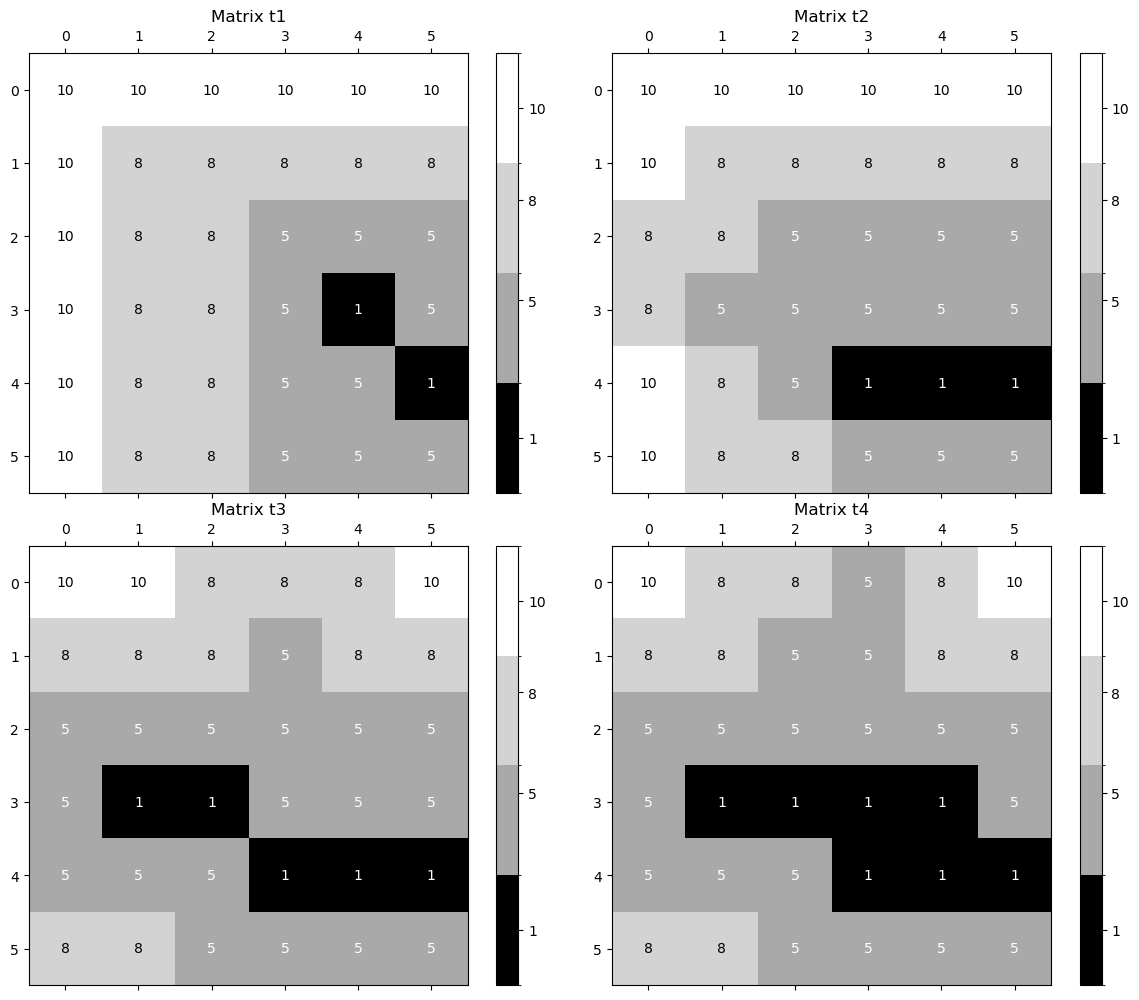

In [77]:
# Create grid
grid = RasterModelGrid ((6,6), 1)

# Define the matrices
t1 = np.array([[10, 10, 10, 10, 10, 10], 
              [10,  8,  8,  8,  8,  8], 
              [10,  8,  8,  5,  5,  5], 
              [10,  8,  8,  5,  1,  5], 
              [10,  8,  8,  5,  5,  1],
              [10,  8,  8,  5,  5,  5]])

t2 = np.array([[10, 10, 10, 10, 10, 10], 
              [10,  8,  8,  8,  8,  8], 
              [ 8,  8,  5,  5,  5,  5], 
              [ 8,  5,  5,  5,  5,  5], 
              [10,  8,  5,  1,  1,  1],
              [10,  8,  8,  5,  5,  5]])

t3 = np.array([[10, 10,  8,  8,  8, 10], 
              [ 8,  8,  8,  5,  8,  8], 
              [ 5,  5,  5,  5,  5,  5], 
              [ 5,  1,  1,  5,  5,  5], 
              [ 5,  5,  5,  1,  1,  1],
              [ 8,  8,  5,  5,  5,  5]])

t4 = np.array([[10,  8,  8,  5,  8, 10], 
              [ 8,  8,  5,  5,  8,  8], 
              [ 5,  5,  5,  5,  5,  5], 
              [ 5,  1,  1,  1,  1,  5], 
              [ 5,  5,  5,  1,  1,  1],
              [ 8,  8,  5,  5,  5,  5]])

# Define a colormap
cmap = mcolors.ListedColormap(['black', 'darkgray', 'lightgray', 'white'])
bounds = [0, 2, 6, 9, 11]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Create the figure and axes
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Create a figure with 1 row and 3 columns

# Function to plot a matrix with annotations
def plot_matrix(matrix, ax, title):
    cax = ax.matshow(matrix, cmap=cmap, norm=norm)
    ax.set_title(title)
    for (i, j), val in np.ndenumerate(matrix):
        color = 'white' if val < 6 else 'black'  # Choose text color based on background color for better contrast
        ax.text(j, i, f'{val}', ha='center', va='center', color=color)
    return cax

# Plot each matrix
cax1 = plot_matrix(t1, axes[0,0], 'Matrix t1')
cax2 = plot_matrix(t2, axes[0,1], 'Matrix t2')
cax3 = plot_matrix(t3, axes[1,0], 'Matrix t3')
cax3 = plot_matrix(t4, axes[1,1], 'Matrix t4')

# Add color bars
fig.colorbar(cax1, ax=axes[0,0], ticks=[1, 5, 8, 10])
fig.colorbar(cax2, ax=axes[0,1], ticks=[1, 5, 8, 10])
fig.colorbar(cax3, ax=axes[1,0], ticks=[1, 5, 8, 10])
fig.colorbar(cax3, ax=axes[1,1], ticks=[1, 5, 8, 10])

# Adjust layout
plt.tight_layout()
plt.show()

To match the gridding structure of landlab, we need to reverse the rows of the matrix t1 without altering the columns. This is a common operation in Python for flipping a 2D array (or matrix) along its vertical axis.

Then we need to join the matrices in one array


In [78]:
t1 = t1[::-1,:]
t2 = t2[::-1,:]
t3 = t3[::-1,:]
t4 = t4[::-1,:]

# Define the matrices as a list
matrices = [t1, t2, t3, t4]  # Add more matrices as needed

To perform the pixel analysis, its necessary to define a timestep, or sequence, so the plotting of the entropy can be analyzed across the experiments. It can be the timestep, or an arbitrary sequence.

In [79]:
# Define time steps
time_steps = [1, 2, 3, 4]

Now we call the function to calculate the Shannon entropy for all experiments

max k is:  7.0


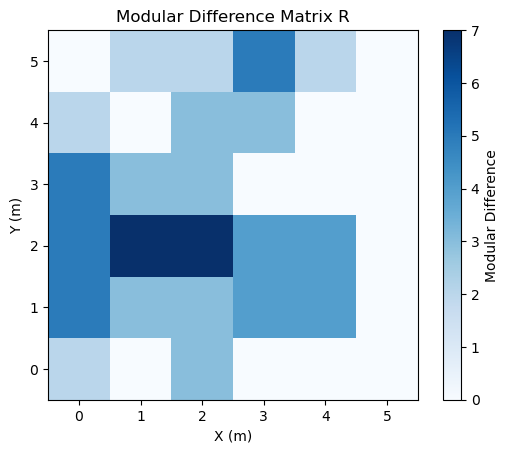

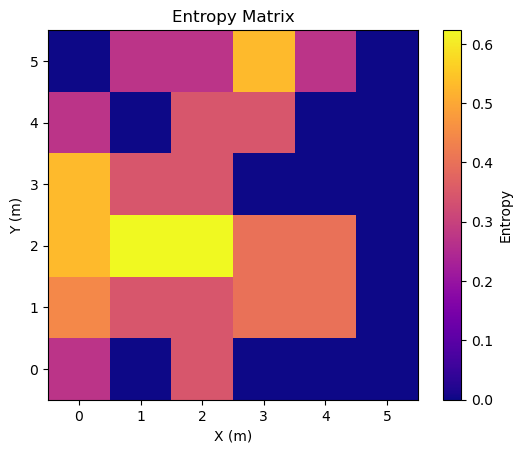

In [80]:
ent_matrix, _ = calculate_shannon_entropy(grid, matrices)

Now we call the function to calculate the Shannon entropy between consecutive matrices, under a pixel view

k global is:  7.0
Pixel with highest absolute value: (2, 1) -> Value: 7.0


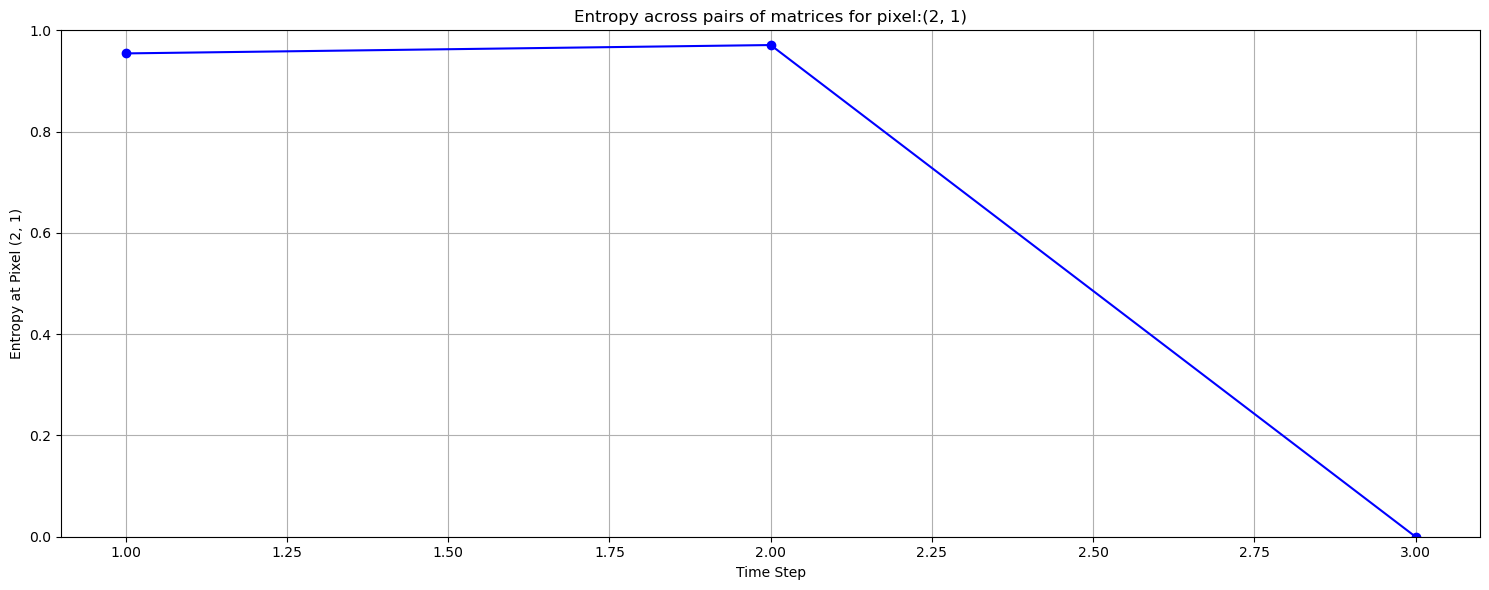

In [81]:
pix_ent = pixel_entropy_across_experiments (grid, matrices)

## An overview of the metrics, before starting the analysis

### *Moran's I*

Developed by Patrick Alfred Pierce Moran to understand the distribution of soil fertility over a field, or the relations between the velocities at different points in a turbulent fluid, Moran’s Index is one of the oldest statistics used to explore spatial autocorrelation, using both feature locations and feature values simultaneously (Moran, 1950). The index is produced by standardizing the spatial autocovariance by the variance of the data. It is calculated using the following equation: 

$$ I = \frac{N}{S_{0}} * \frac{\sum_{i=1}^{N} \sum_{i=1}^{N} w(i,j)(x_{i} - \bar{x})(x_{j} - \bar{x})}{\sum_{i=1}^{N} (x_{i} - \bar{x})} ; j \neq i $$

Where:
- $\bar{x}$ is the mean of $x_{i}$.
- w(i,j) is the spatial weight between feature i and j.
- n is the total number of features
- $S_{0}$ is the aggregate of all spatial weights

The resulting Moran's I statistic ranges from -1 to 1. Negative values suggest a negative spatial correlation, indicating that neighboring features tend to have dissimilar values. Values near 0 indicate no spatial correlation, suggesting a random spatial distribution. Positive values indicate a positive spatial correlation, implying that neighboring features tend to have similar values.

Moran's I finds extensive application in various fields such as geography, urban planning, ecology, and epidemiology. It helps researchers and practitioners understand spatial patterns, identify clusters, and make informed decisions about resource allocation, policy formulation, and spatial planning. In summary, Moran's I provides a valuable tool for exploring spatial relationships and patterns within dataset.

- *p-value:*
The p-value in the context of Moran's I assesses the significance of the observed spatial autocorrelation. A low p-value indicates that the observed pattern is unlikely to have occurred by chance.

### *Geary's C*

Geary’s c is a statistic used to measure spatial autocorrelation by quantifying the covariation between pairs of data values. Developed by Frank Brian Geary, it utilizes the sum of squared differences between pairs of data values to assess spatial relationships (Geary, 1954).

The calculation of Geary’s contiguity ratio “c” involves comparing the observed sum of squared differences to the expected sum under the assumption of spatial randomness.
Geary's C is another measure of spatial autocorrelation. It is more sensitive to local spatial autocorrelation compared to Moran's I.

Mathematically, Geary's C is defined as:

$$ c = \frac{N - 1}{2 S_{0}} * \frac{\sum_{i=1}^{N} \sum_{i=1}^{N} w(i,j)(x_{i} - x_{j})^2}{\sum_{i=1}^{N} (x_{i} - \bar{x})} ; j \neq i $$

Where:
- $\bar{x}$ is the mean of $x_{i}$.
- w(i,j) is the spatial weight between feature i and j.
- n is the total number of features
- $S_{0}$ is the aggregate of all spatial weights

The p-value in the context of Geary's C assesses the significance of the observed spatial autocorrelation. A low p-value indicates that the observed pattern is unlikely to have occurred by chance.

The expected value for Geary’s c is 1. Values lower than 1 indicate positive spatial autocorrelation, suggesting that nearby data values tend to be more similar than expected under spatial randomness. Conversely, values larger than 1 indicate negative spatial autocorrelation, implying that nearby data values tend to be more dissimilar than expected.
<br>
<br>

**How is the algorithm working?**
- *Spatial Weights Matrix:*
First, a spatial weights matrix is created, based on the lattice structure of the first matrix. This matrix captures the spatial relationship between the cells.

w = lat2W(matrices[0].shape[0], matrices[0].shape[1]) 
<br>
<br>
- *Index Calculation:*

For each matrix (representing a different time step), compute Moran's I / Geary's c.
Store the resulting values and their corresponding p-values.
<br>
<br>
- *Display and Plot:* 

Print index values on the primary y-axis, and p-values on the secondary y-axis for each time step.
Annotate the plots to enhance readability and provide more information.
<br>
<br>
- *Mathematical Perspective:*

Index Calculation: Each cell's index value is calculated considering the spatial weights and the values of neighboring cells.

p-value Calculation: The p-value assesses the statistical significance of the observed index, indicating how likely it is that the observed spatial autocorrelation is due to random chance.

This function provides a comprehensive analysis of spatial autocorrelation over time, visually representing the changes in index and their significance.
<br>
<br>
For this example, we will use the following libraries:

In [82]:
#%% Import libraries
from libpysal.weights import lat2W
from esda.moran import Moran
from esda.geary import Geary

And the following functions:

In [83]:
def plot_morans_i_over_time(matrices, time_steps):
    """
    Calculates and plots Moran's I and p-values over multiple time steps.

    Parameters:
    - matrices: list of 2D numpy arrays representing different time steps.
    - time_steps: list of integers representing the time steps.
    """
    # Create the matrix of weights 
    w = lat2W(matrices[0].shape[0], matrices[0].shape[1])

    # Calculate Moran's I and p-values for each matrix
    moran_values = []
    p_values = []
    for matrix in matrices:
        mi = Moran(matrix, w)
        moran_values.append(mi.I)
        p_values.append(mi.p_norm)

    # Display Moran's I values and p-values
    for i, (mi_val, p_val) in enumerate(zip(moran_values, p_values)):
        print(f"Time Step {i+1} - Moran's I: {mi_val:.4f}, p-value: {p_val:.4f}")
    
    # Plot Moran's I vs. Time Steps
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot Moran's I values
    color = 'tab:blue'
    ax1.set_xlabel("Time Step")
    ax1.set_ylabel("Moran's I", color=color)
    ax1.plot(time_steps, moran_values, marker='o', color=color, label="Moran's I")
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.axhline(y=0, color='red', linestyle='--', label="Moran's I = 0")
    ax1.set_ylim(-1, 1)

    # Annotate each point with Moran's I value
    for i, mi_val in enumerate(moran_values):
        ax1.annotate(f'{mi_val:.3f}', (time_steps[i], mi_val), textcoords="offset points", xytext=(0,10), ha='center')

    # Create a second y-axis for p-values
    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel("p-value", color=color)
    ax2.plot(time_steps, p_values, marker='s', linestyle='--', color=color, label="p-value")
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(-0.01, 0.1)

    # Annotate each point with p-value
    for i, p_val in enumerate(p_values):
        ax2.annotate(f'{p_val:.2f}', (time_steps[i], p_val), textcoords="offset points", xytext=(0,-15), ha='center')

    fig.tight_layout()  # Adjust layout to make room for annotations
    fig.suptitle("Moran's I and p-value over Time Steps", y=1)
    plt.show()
    
def plot_gearys_c_over_time(matrices, time_steps):
    """
    Calculates and plots Geary's C and p-values over multiple time steps.

    Parameters:
    - matrices: list of 2D numpy arrays representing different time steps.
    - time_steps: list of integers representing the time steps.
    """
    # Create the matrix of weights 
    w = lat2W(matrices[0].shape[0], matrices[0].shape[1])

    # Calculate Geary's C and p-values for each matrix
    geary_values = []
    p_values = []
    for matrix in matrices:
        gc = Geary(matrix, w)
        geary_values.append(gc.C)
        p_values.append(gc.p_norm)

    # Display Geary's C values and p-values
    for i, (gc_val, p_val) in enumerate(zip(geary_values, p_values)):
        print(f"Time Step {i+1} - Geary's C: {gc_val:.4f}, p-value: {p_val:.4f}")
    
    # Plot Geary's C vs. Time Steps
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot Geary's C values
    color = 'tab:red'
    ax1.set_xlabel("Time Step")
    ax1.set_ylabel("Geary's C", color=color)
    ax1.plot(time_steps, geary_values, marker='o', color=color, label="Geary's C")
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.axhline(y=1, color='blue', linestyle='--', label="Geary's C = 1")
    ax1.set_ylim(0, 2)

    # Annotate each point with Geary's C value
    for i, gc_val in enumerate(geary_values):
        ax1.annotate(f'{gc_val:.3f}', (time_steps[i], gc_val), textcoords="offset points", xytext=(0,10), ha='center')

    # Create a second y-axis for p-values
    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel("p-value", color=color)
    ax2.plot(time_steps, p_values, marker='s', linestyle='--', color=color, label="p-value")
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(-0.01, 0.1)

    # Annotate each point with p-value
    for i, p_val in enumerate(p_values):
        ax2.annotate(f'{p_val:.2f}', (time_steps[i], p_val), textcoords="offset points", xytext=(0,-15), ha='center')

    fig.tight_layout()  # Adjust layout to make room for annotations
    fig.suptitle("Geary's C and p-value over Time Steps", y=1)
    plt.show()


Time Step 1 - Moran's I: 0.7092, p-value: 0.0000
Time Step 2 - Moran's I: 0.7145, p-value: 0.0000
Time Step 3 - Moran's I: 0.5830, p-value: 0.0000
Time Step 4 - Moran's I: 0.5843, p-value: 0.0000


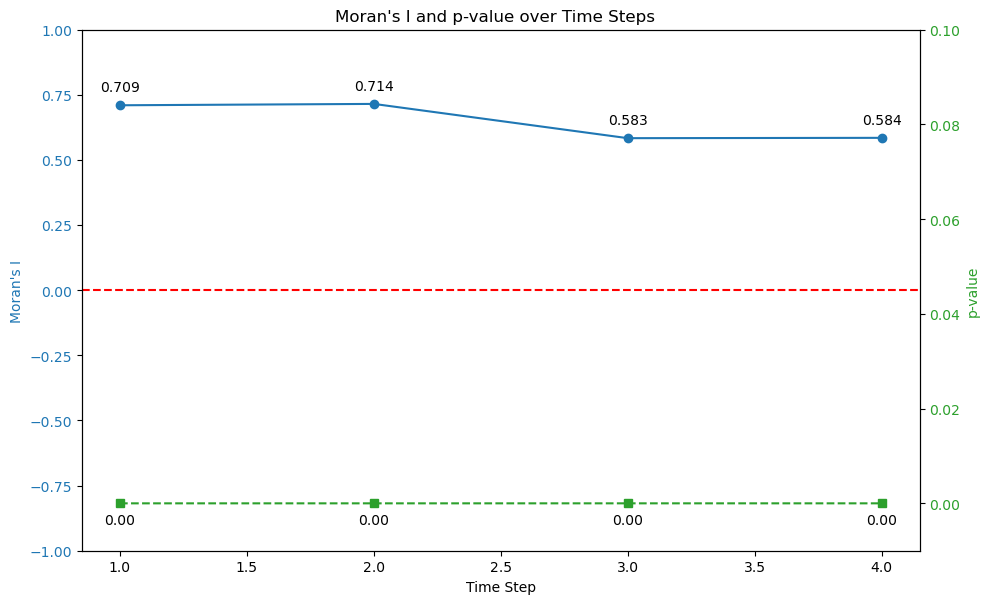

Time Step 1 - Geary's C: 0.2814, p-value: 0.0000
Time Step 2 - Geary's C: 0.2840, p-value: 0.0000
Time Step 3 - Geary's C: 0.4047, p-value: 0.0000
Time Step 4 - Geary's C: 0.3971, p-value: 0.0000


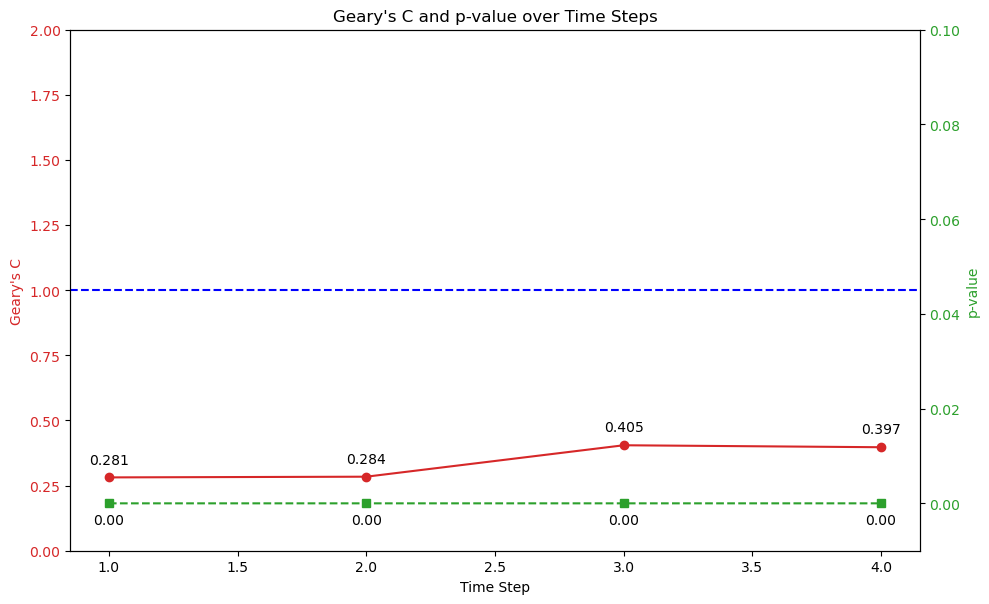

In [84]:
time_steps 
plot_morans_i_over_time(matrices, time_steps)
plot_gearys_c_over_time(matrices, time_steps)


### *Entropy with Mask*

Going back to entropy, applying the method to the whole area might mask softer contrats in the hillslope area.

The first step, then, is to differentiate hillslope and stream:

**How to differentiate Hillslope and Stream?**

- “Hydrological connectivity between uplands (also known as the hillslopes) and the stream or riparian network has been defined in many ways, but perhaps it is most commonly used to describe when water tables develop between the hillslope and riparian zone [Vidon and Hill, 2004; Ocampo et al., 2006] and result in a measurable runoff response [Bracken and Croke, 2007]”.

- Depends on catchment wetness, soil properties and surface and bedrock topography and in some cases, hillslopes only rarely connect to the stream environment.

- Nevertheless, quantifying these connections at the catchment scale is difficult because hillslope contributions are often initiated only after exceeding a storage threshold [Spence and Woo, 2003; Buttle et al., 2004; Kim et al., 2004; Tromp‐van Meerveld and McDonnell, 2006a, 2006b; Detty and McGuire, 2010b] or they are obscured by throughflow spatial variability and preferential flow.

In summary, that is not a trivial task. Differentiating between hillslopes and streams in a landscape evolution model involves identifying areas dominated by fluvial processes (streams) versus those dominated by diffusive processes (hillslopes). Here are a few approaches to achieve this:

- Threshold Drainage Area: Streams can be identified by areas where the drainage area exceeds a certain threshold. Hillslopes, on the other hand, will have lower drainage areas. 

- Slope Analysis: Streams often have higher slopes compared to hillslopes. You can use slope thresholds to differentiate between them.

- Erosion Rate: Streams typically exhibit higher erosion rates due to concentrated flow, whereas hillslopes have lower erosion rates.

First we will run a simple model and save some outputs to perform our calculations:


500
1000
1500
2000
2500
3000
3500
4000
4500


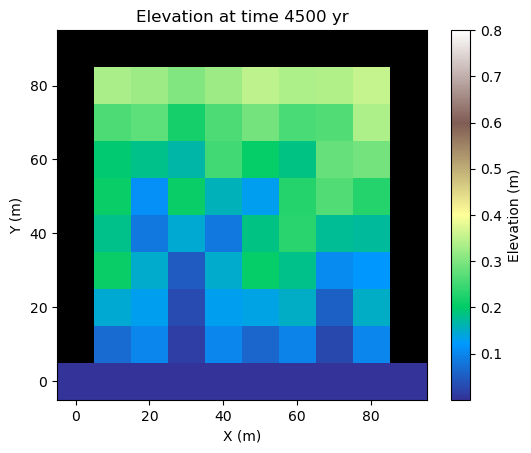

Maximum elevation is  0.356085233493
5000


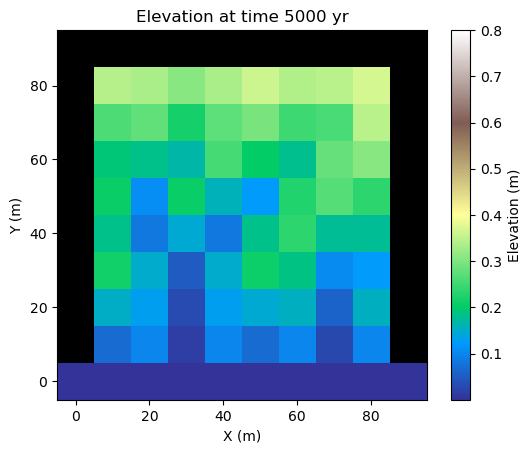

Maximum elevation is  0.367205323315
5500


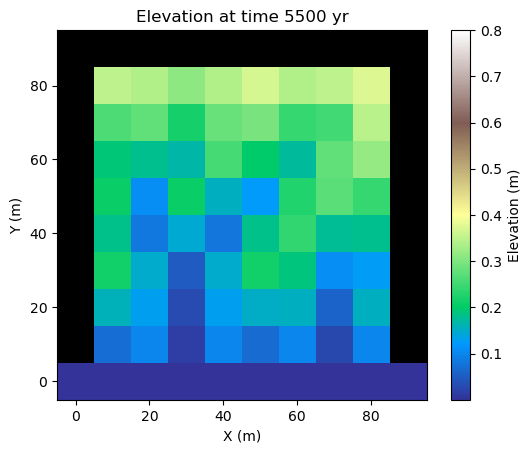

Maximum elevation is  0.374067532299
6000


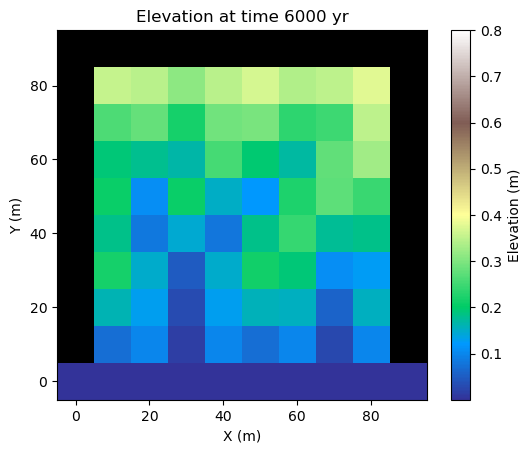

Maximum elevation is  0.378011617138


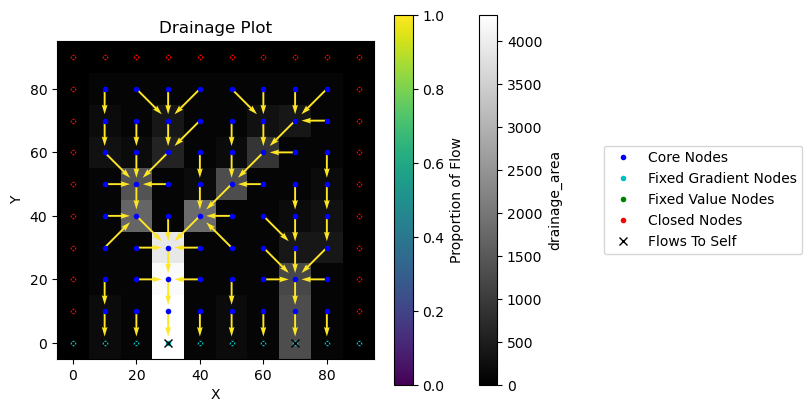

In [85]:
from landlab import RasterModelGrid, imshow_grid, imshowhs_grid
from landlab.components import (
    FlowAccumulator,
    StreamPowerEroder,
)
from landlab.plot.drainage_plot import drainage_plot

# Model grid
number_of_rows = 10  # number of raster cells in vertical direction (y)
number_of_columns = 10  # number of raster cells in horizontal direction (x)
dxy = 10  # side length of a raster model cell, or resolution [m]
mg1 = RasterModelGrid((number_of_rows, number_of_columns), dxy)
mg1.set_closed_boundaries_at_grid_edges(True, True, True, False) # Set boundary conditions

# Initialize landscape
np.random.seed(35)  # seed set so our figures are reproducible
mg1_noise = (np.random.rand(mg1.number_of_nodes) / 1000.0)  # initial noise on elevation grid
z1 = mg1.add_zeros("topographic__elevation", at="node") # set up the elevation on the grid
z1 += mg1_noise

# Timesteps
tmax = 6000  # time for the model to run [yr] (Original value was 5E5 yr)
dt = 500  # time step [yr] (Original value was 100 yr)
total_time = 0  # amount of time the landscape has evolved [yr]
t = np.arange(0, tmax, dt)  # each of the time steps that the code will run

# Original K_sp value is 1e-5
K_sp = 1.0e-3  # units vary depending on m_sp and n_sp
m_sp = 0.5  # exponent on drainage area in stream power equation
n_sp = 1.0  # exponent on slope in stream power equation

frr = FlowAccumulator(mg1, flow_director="FlowDirectorD8")  # initializing flow routing
spr = StreamPowerEroder(mg1, K_sp=K_sp, m_sp=m_sp, n_sp=n_sp, threshold_sp=0.0)  # initializing stream power incision
theta = m_sp / n_sp

uplift_rate = np.ones(mg1.number_of_nodes) * 0.0001

# Model runs

mg1_snapshots = []  # List to store mg1 state at each timestep
stream_masks = []

for ti in t:
    z1[mg1.core_nodes] += uplift_rate[mg1.core_nodes] * dt  # uplift the landscape
    frr.run_one_step()  # route flow
    spr.run_one_step(dt)  # fluvial incision
    total_time += dt  # update time keeper
    print(total_time)
    
    if ti > 3500:
        # Save a snapshot of mg1 state
        z1_rshpd = z1.reshape(mg1.shape)
        mg1_snapshots.append(z1_rshpd.copy())
        # Plots snapshots used for entropy calculation
        plt.figure()
        imshow_grid(mg1, z1, grid_units=("m", "m"),cmap='terrain', var_name="Elevation (m)", vmax = 0.8)
        plt.title(f"Elevation at time {total_time} yr")
        plt.show()
      
        max_elev = np.max(z1)
        print("Maximum elevation is ", np.max(z1))
        
        
plt.figure()
drainage_plot(mg1, 'drainage_area')

As shown in the last figure, the drainage area is defined by the amount of cells that flow to the analyzed cell. In the functions below, the drainage areas are all normalized by the area, to make the definition easier.

Here we will use the treshold drainage area:

### The Function ###

The "differentiate_hillslopes_and_streams" function aims to help the user differentiate streams and hillslobes based on drainage area.

Parameters:
- grid (RasterModelGrid): The Landlab model grid.
- elevations: List of elevation arrays at different time steps.
- stream_threshold (float): Threshold for drainage area to classify as stream.

Returns:
- tot_stream_mask (np.ndarray): Total Boolean mask indicating stream nodes across all time steps.

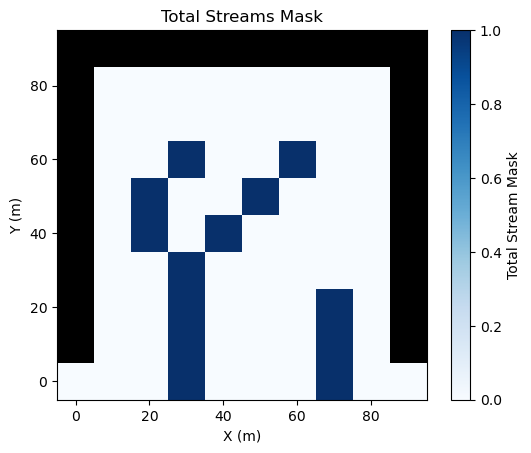

In [86]:
def differentiate_hillslopes_and_streams(grid, elevations, stream_threshold=4):
    """
    Function to differentiate hillslopes and streams based on drainage area and slope thresholds.
    
    Parameters:
    - grid (RasterModelGrid): The Landlab model grid.
    - elevations: List of elevation arrays at different time steps.
    - stream_threshold (float): Threshold for drainage area to classify as stream.

    Returns:
    - tot_stream_mask (np.ndarray): Total Boolean mask indicating stream nodes across all time steps.
    """
    stream_masks = []
    dxy = grid.dx

    for elevation in elevations:
        # Set the elevation data to the grid
        grid.at_node['topographic__elevation'] = elevation

        # Calculate drainage area
        fa = FlowAccumulator(grid, flow_director="FlowDirectorD8")
        fa.run_one_step()
        drainage_area = grid.at_node['drainage_area']

        # Calculate slope
        slope = grid.calc_slope_at_node()

        # Reshape for plotting and classification
        drainage_area = drainage_area.reshape(grid.shape)/(dxy**2)
        slope = slope.reshape(grid.shape)

        # Classify nodes
        stream_mask = (drainage_area > stream_threshold) #| (slope > slope_threshold)
        stream_masks.append(stream_mask)
        
    # Sum the stream masks
    tot_stream_mask = np.any(stream_masks, axis=0)
    plt.figure()
    imshow_grid(grid, tot_stream_mask.astype(int), grid_units=("m", "m"), var_name="Total Stream Mask", cmap="Blues")
    plt.title("Total Streams Mask")
    plt.show()

    return tot_stream_mask

matrices = mg1_snapshots
stream_mask = differentiate_hillslopes_and_streams(mg1, matrices)

Another way to approach this is by using a buffer to delimitate an area around the streams:

### The Function ###

The "diff_hslp_and_strm_buff" function aims to help the user differentiate streams and hillslobes based on drainage area with a buffer around the streams.

Parameters:
- grid (RasterModelGrid): The Landlab model grid.
- elevations: List of elevation arrays at different time steps.
- stream_threshold (float): Threshold for drainage area to classify as stream.
- filter_size (int): Size of the maximum filter to create buffer around streams.

Returns:
- tot_stream_mask (np.ndarray): Total Boolean mask indicating stream nodes across all time steps.

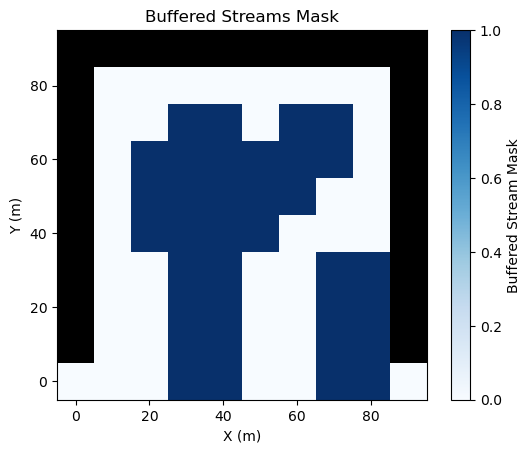

max slope is:  0.0109883726285


In [87]:
from scipy.ndimage import maximum_filter

def diff_hslp_and_strm_buff(grid, elevations, stream_threshold=4, filter_size=3):
    """
    Function to differentiate hillslopes and streams based on drainage area and slope thresholds with buffer.
    
    Parameters:
    - grid (RasterModelGrid): The Landlab model grid.
    - elevations: List of elevation arrays at different time steps.
    - stream_threshold (float): Threshold for drainage area to classify as stream.
    - filter_size (int): Size of the maximum filter to create buffer around streams.

    Returns:
    - tot_stream_mask (np.ndarray): Total Boolean mask indicating stream nodes across all time steps.
    """
    stream_masks = []
    dxy = grid.dx
    slopes = []

    for elevation in elevations:
        # Set the elevation data to the grid
        grid.at_node['topographic__elevation'] = elevation

        # Calculate drainage area
        fa = FlowAccumulator(grid, flow_director="FlowDirectorD8")
        fa.run_one_step()
        drainage_area = grid.at_node['drainage_area']

        # Calculate slope
        slope = grid.calc_slope_at_node()

        # Reshape for plotting and classification
        drainage_area = drainage_area.reshape(grid.shape)/(dxy**2)
        # print(drainage_area)
        slope = slope.reshape(grid.shape)
        slopes.append(slope)

        # Classify nodes
        stream_mask = (drainage_area > stream_threshold) #| (slope > slope_threshold)
        stream_masks.append(stream_mask)

    # Sum the stream masks
    tot_stream_mask = np.any(stream_masks, axis=0)
    buffered_stream_mask = maximum_filter(tot_stream_mask.astype(int), size=filter_size).astype(bool)

    plt.figure()
    imshow_grid(grid, buffered_stream_mask.astype(int), grid_units=("m", "m"), var_name="Buffered Stream Mask", cmap="Blues")
    plt.title("Buffered Streams Mask")
    plt.show()
    
    max_slope = np.max(slopes)
    print("max slope is: ", max_slope)

    return buffered_stream_mask

stream_mask_buff = diff_hslp_and_strm_buff(mg1, matrices, filter_size=2)

And if you have more knowledge/confidence on your data, it is possible to scale the buffer to your drainage area:

### The Function ###

The "diff_hslp_and_strm_scal_buff" function aims to help the user differentiate streams and hillslobes based on drainage area with a scaled buffer around the streams. It means that the buffer is scaled from the drainage area.

Parameters:
- grid (RasterModelGrid): The Landlab model grid.
- elevations: List of elevation arrays at different time steps.
- stream_threshold (float): Threshold for drainage area to classify as stream.
- buffer_scaling_factor (float): Factor to scale the buffer size based on drainage area.
- minimum_buffer_size: Size of the minimum filter to create buffer around streams.

Returns:
- tot_stream_mask (np.ndarray): Total Boolean mask indicating stream nodes across all time steps.

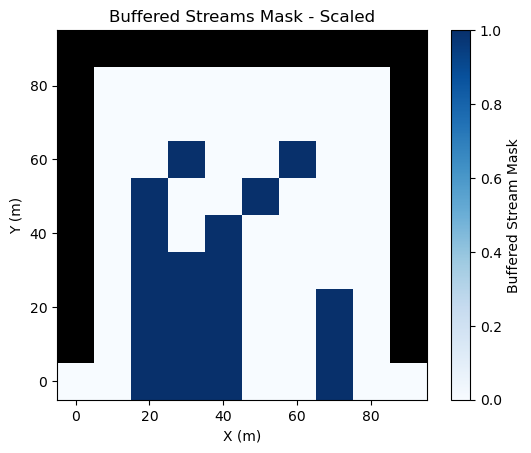

max slope is:  0.0109883726285


In [88]:
def diff_hslp_and_strm_scal_buff(grid, elevations, stream_threshold=4, buffer_scaling_factor=0.00015, minimum_buffer_size=0.5):
    """
    Function to differentiate hillslopes and streams based on drainage area and slope thresholds with scaled buffer.
    
    Parameters:
    - grid (RasterModelGrid): The Landlab model grid.
    - elevations: List of elevation arrays at different time steps.
    - stream_threshold (float): Threshold for drainage area to classify as stream.
    - buffer_scaling_factor (float): Factor to scale the buffer size based on drainage area.

    Returns:
    - tot_stream_mask (np.ndarray): Total Boolean mask indicating stream nodes across all time steps.
    """
    stream_masks = []
    dxy = grid.dx
    slopes = []

    for elevation in elevations:
        # Set the elevation data to the grid
        grid.at_node['topographic__elevation'] = elevation

        # Calculate drainage area
        fa = FlowAccumulator(grid, flow_director="FlowDirectorD8")
        fa.run_one_step()
        drainage_area = grid.at_node['drainage_area']

        # Calculate slope
        slope = grid.calc_slope_at_node()

        # Reshape for plotting and classification
        drainage_area = drainage_area.reshape(grid.shape) / (dxy**2)
        slope = slope.reshape(grid.shape)
        slopes.append(slope)

        # Classify nodes
        stream_mask = (drainage_area > stream_threshold)
        stream_masks.append(stream_mask)

    # Sum the stream masks
    tot_stream_mask = np.any(stream_masks, axis=0)

    # Calculate buffer size dynamically based on drainage area
    buffer_size_array = (drainage_area * buffer_scaling_factor).astype(int)
    buffer_size_array[buffer_size_array < 1] = minimum_buffer_size  # Ensure minimum buffer size is 1

    # Initialize the buffered stream mask
    buffered_stream_mask = np.zeros_like(tot_stream_mask)

    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if tot_stream_mask[i, j]:
                buffer_size = buffer_size_array[i, j]
                buffered_stream_mask[max(0, i-buffer_size):min(grid.shape[0], i+buffer_size+1),
                                     max(0, j-buffer_size):min(grid.shape[1], j+buffer_size+1)] = 1

    buffered_stream_mask = buffered_stream_mask.astype(bool)

    plt.figure()
    imshow_grid(grid, buffered_stream_mask.astype(int), grid_units=("m", "m"), var_name="Buffered Stream Mask", cmap="Blues")
    plt.title("Buffered Streams Mask - Scaled")
    plt.show()

    max_slope = np.max(slopes)
    print("max slope is: ", max_slope)

    return buffered_stream_mask

stream_mask_scl_buff = diff_hslp_and_strm_scal_buff(mg1, matrices, buffer_scaling_factor=0.025)

Then it's possible to calculate the entropy for the different areas separately:

### The Function ###

The "calculate_shannon_entropy_mask" function aims to help the user calculate Shannon's entropy separately for the stream and hillslope area

Parameters:
- grid: RasterModelGrid object
- matrices: List of matrices (numpy arrays) to compare
- stream_mask: Boolean mask indicating stream nodes
- k_stream: Maximum modular difference for stream region (optional)
- k_hillslope: Maximum modular difference for hillslope region (optional)

Returns:
- entropy_matrix_stream: The calculated entropy matrix for stream regions
- entropy_matrix_hillslope: The calculated entropy matrix for hillslope regions
- probabilities_stream: The calculated probabilities for each element in stream regions
- probabilities_hillslope: The calculated probabilities for each element in hillslope regions

k_stream is:  0.0153591827779
k_hillslope is:  0.0367097664061


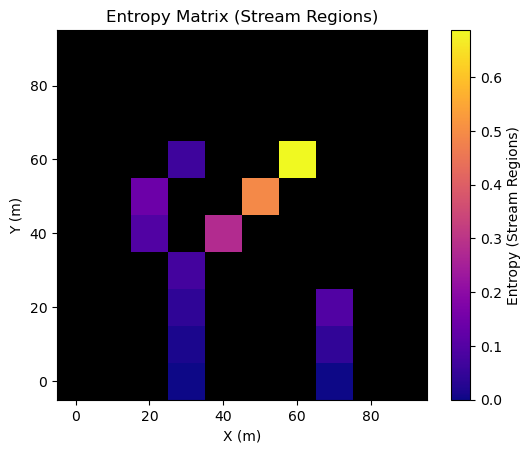

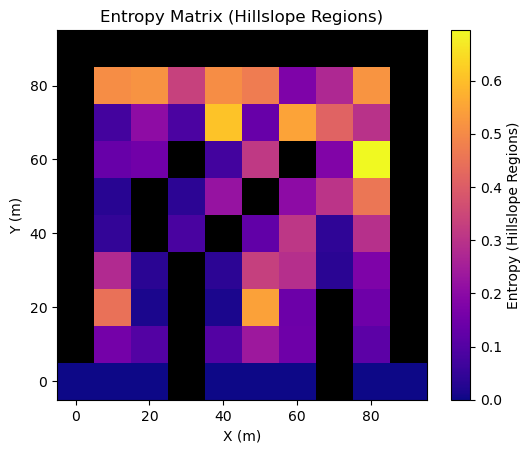

In [89]:
def calculate_shannon_entropy_mask(grid, matrices, stream_mask, k_stream=None, k_hillslope=None):
    """
    Calculate the entropy based on the difference between matrices,
    separately for stream and hillslope areas based on a mask.

    Parameters:
    - grid: RasterModelGrid object
    - matrices: List of matrices (numpy arrays) to compare
    - stream_mask: Boolean mask indicating stream nodes
    - k_stream: Maximum modular difference for stream region (optional)
    - k_hillslope: Maximum modular difference for hillslope region (optional)

    Returns:
    - entropy_matrix_stream: The calculated entropy matrix for stream regions
    - entropy_matrix_hillslope: The calculated entropy matrix for hillslope regions
    - probabilities_stream: The calculated probabilities for each element in stream regions
    - probabilities_hillslope: The calculated probabilities for each element in hillslope regions
    """
    n = len(matrices)  # number of elements

    # Calculate k for stream regions if not provided
    if k_stream is None:
        R_stream = np.zeros(grid.shape)
        for i in range(R_stream.shape[0]):
            for j in range(R_stream.shape[1]):
                if stream_mask[i, j]:
                    R_stream[i, j] = max(abs(matrices[m][i, j] - matrices[(m + 1) % n][i, j]) for m in range(n))
        k_stream = np.max(R_stream)
        print("k_stream is: ", k_stream)

    # Calculate k for hillslope regions if not provided
    if k_hillslope is None:
        R_hillslope = np.zeros(grid.shape)
        for i in range(R_hillslope.shape[0]):
            for j in range(R_hillslope.shape[1]):
                if not stream_mask[i, j]:
                    R_hillslope[i, j] = max(abs(matrices[m][i, j] - matrices[(m + 1) % n][i, j]) for m in range(n))
        k_hillslope = np.max(R_hillslope)
        print("k_hillslope is: ", k_hillslope)

    # Calculate probabilities
    probabilities_stream = []
    probabilities_hillslope = []
    for i in range(n):
        j = (i + 1) % n  # Wrap around to the beginning if at the end
        prob_stream = abs(matrices[i] - matrices[j]) / (k_stream * n)
        prob_hillslope = abs(matrices[i] - matrices[j]) / (k_hillslope * n)
        probabilities_stream.append(prob_stream)
        probabilities_hillslope.append(prob_hillslope)

    # Handle case where probability is zero
    probabilities_stream = [np.where(p == 0, 1, p) for p in probabilities_stream]
    probabilities_hillslope = [np.where(p == 0, 1, p) for p in probabilities_hillslope]

    # Initialize entropy matrices for stream and hillslope regions
    entropy_matrix_stream = np.zeros(grid.shape)
    entropy_matrix_hillslope = np.zeros(grid.shape)

    for prob_stream, prob_hillslope in zip(probabilities_stream, probabilities_hillslope):
        entropy_matrix_stream[stream_mask] -= prob_stream[stream_mask] * np.log(prob_stream[stream_mask]) / np.log(n)
        entropy_matrix_hillslope[~stream_mask] -= prob_hillslope[~stream_mask] * np.log(prob_hillslope[~stream_mask]) / np.log(n)

    # Set entropy values of non-relevant regions to a high value for visualization
    entropy_matrix_stream[~stream_mask] = np.nan
    entropy_matrix_hillslope[stream_mask] = np.nan
    
    # Create masked arrays to handle np.nan values
    masked_entropy_matrix_stream = np.ma.masked_invalid(entropy_matrix_stream)
    masked_entropy_matrix_hillslope = np.ma.masked_invalid(entropy_matrix_hillslope)


    # Plot entropy matrices for stream and hillslope regions separately
    plt.figure()
    imshow_grid(grid, masked_entropy_matrix_stream, cmap='plasma', grid_units=("m", "m"), var_name="Entropy (Stream Regions)", colorbar_label='Entropy')
    plt.title("Entropy Matrix (Stream Regions)")
    plt.show()

    plt.figure()
    imshow_grid(grid, masked_entropy_matrix_hillslope, cmap='plasma', grid_units=("m", "m"), var_name="Entropy (Hillslope Regions)", colorbar_label='Entropy')
    plt.title("Entropy Matrix (Hillslope Regions)")
    plt.show()

    return masked_entropy_matrix_stream, masked_entropy_matrix_hillslope, probabilities_stream, probabilities_hillslope

entropy_matrix_stream, entropy_matrix_hillslope, _, _ = calculate_shannon_entropy_mask(mg1, matrices, stream_mask)

With the buffer:

k_stream is:  0.0284257643397
k_hillslope is:  0.0367097664061


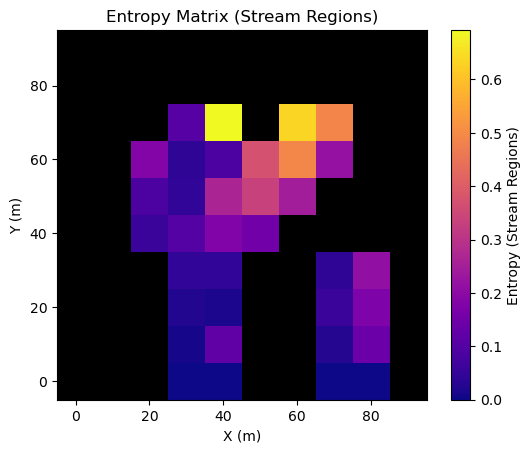

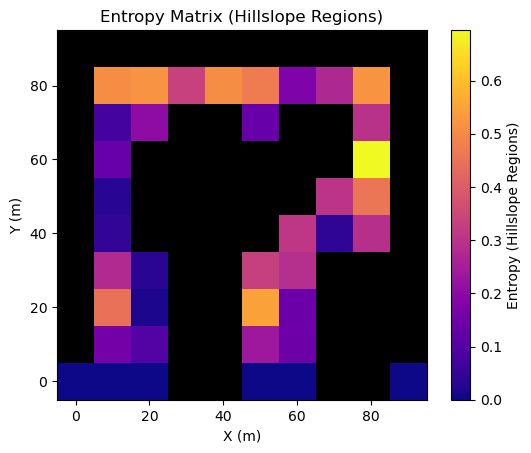

In [90]:
entropy_matrix_stream_buff, entropy_matrix_hillslope_buff, _, _ = calculate_shannon_entropy_mask(mg1, matrices, stream_mask_buff)

And with the scaled buffer:

k_stream is:  0.0153591827779
k_hillslope is:  0.0367097664061


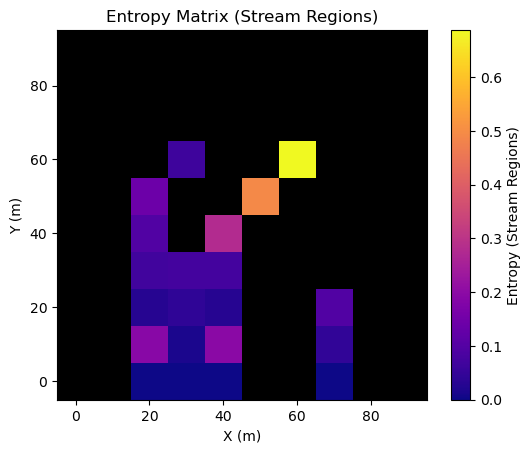

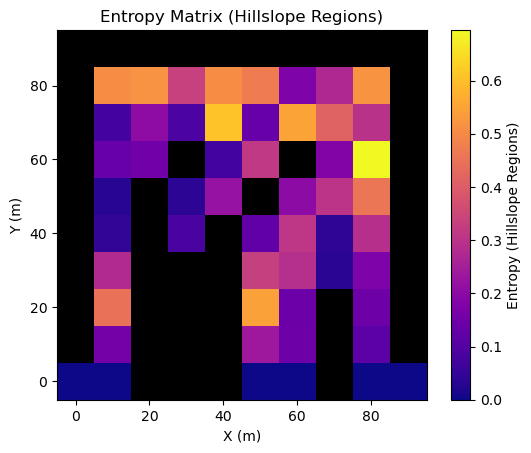

In [91]:
entropy_matrix_stream_sbuff, entropy_matrix_hillslope_sbuff, _, _ = calculate_shannon_entropy_mask(mg1, matrices, stream_mask_scl_buff)

Now if we want to calculate the Shannon entropy between consecutive matrices, under a pixel view:

### The Function ###

The "pixel_entropy_across_experiments_mask" function aims to help the user calculate the entropy of pairs of experiments under the perspective of a pixel. If no pixel is inputted, the function identifies the pixel with highest entropy, in each one of the areas. The function also plots the modular difference between the two matricees, and a hillshaded area with the pixels where the calculations are being derived from are located, in red.

Parameters:
- grid: RasterModelGrid object
- matrices: List of matrices (numpy arrays) to compare
- k_global: Maximum modular difference (optional)
- pixel: Tuple of (row, col) coordinates (optional)

Returns:
- entropies: The calculated Shannon entropies for each pair of experiments,
with a local k derived from the absolute difference between the pair 
of models

k_stream is:  0.0153591827779
Pixel with highest absolute value: (6, 6) -> Value: 0.015359182777856306
k_hillslope is:  0.0367097664061
Pixel with highest absolute value: (6, 8) -> Value: 0.03670976640614709


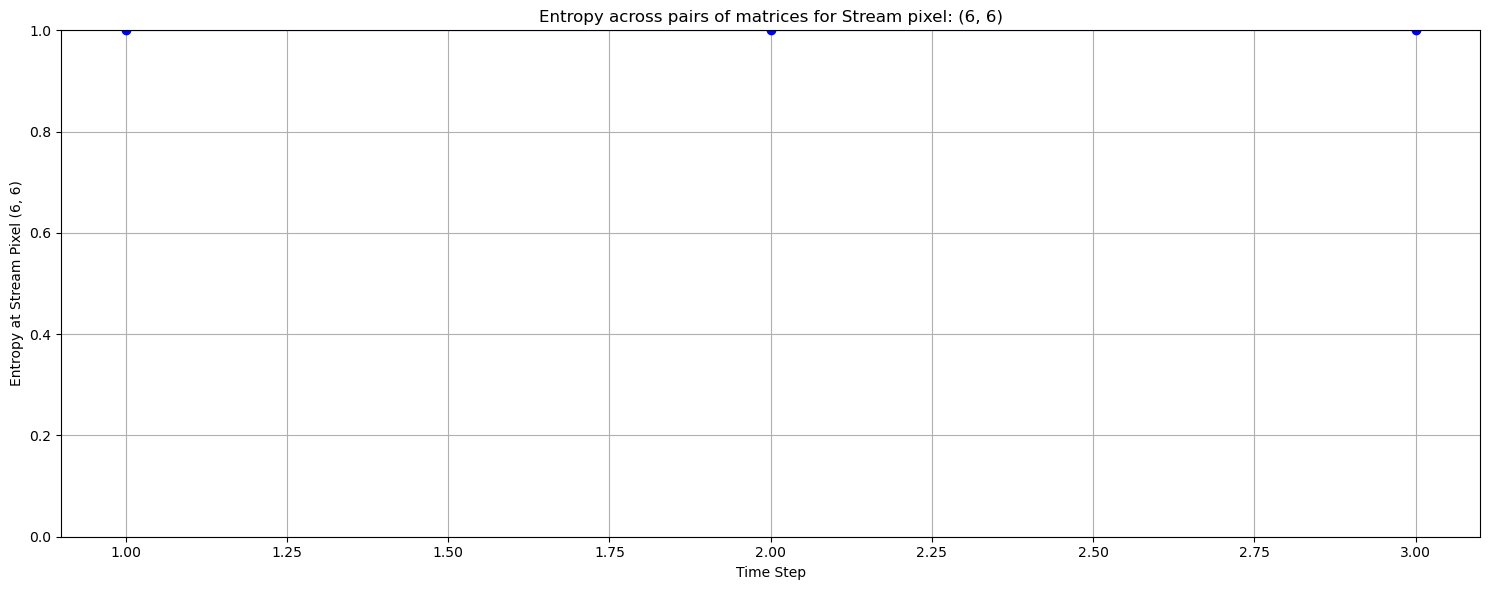

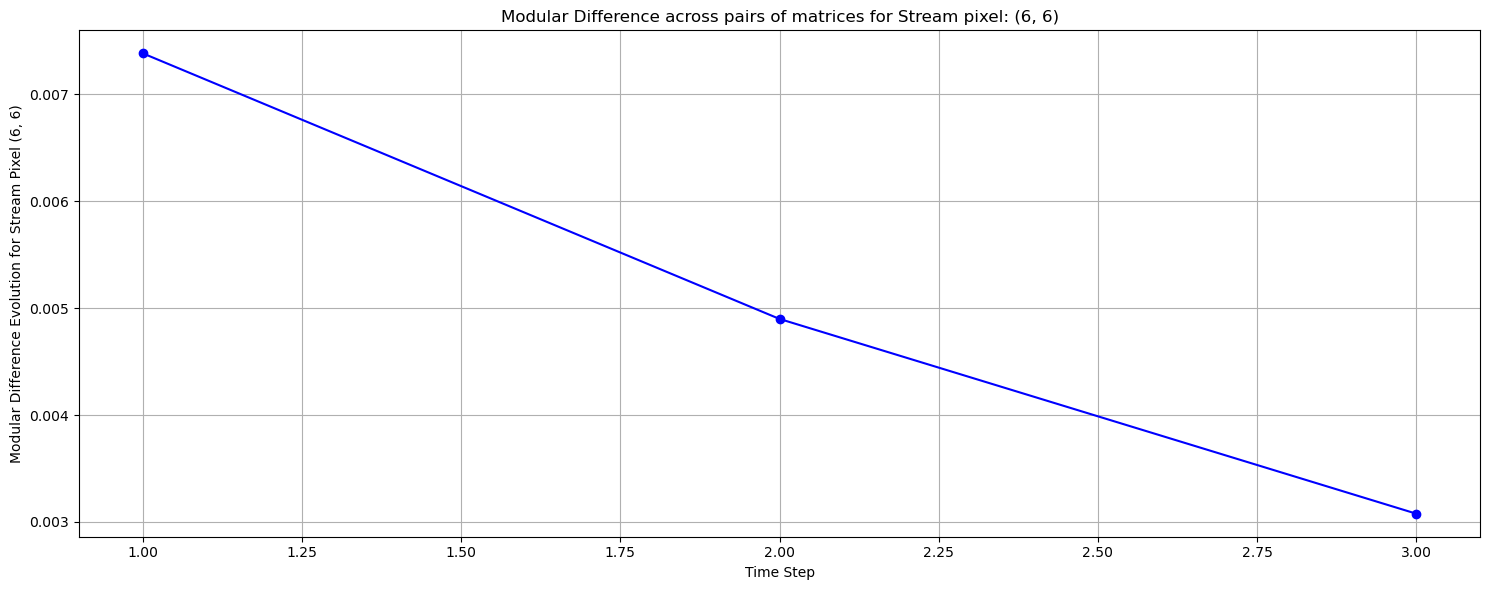

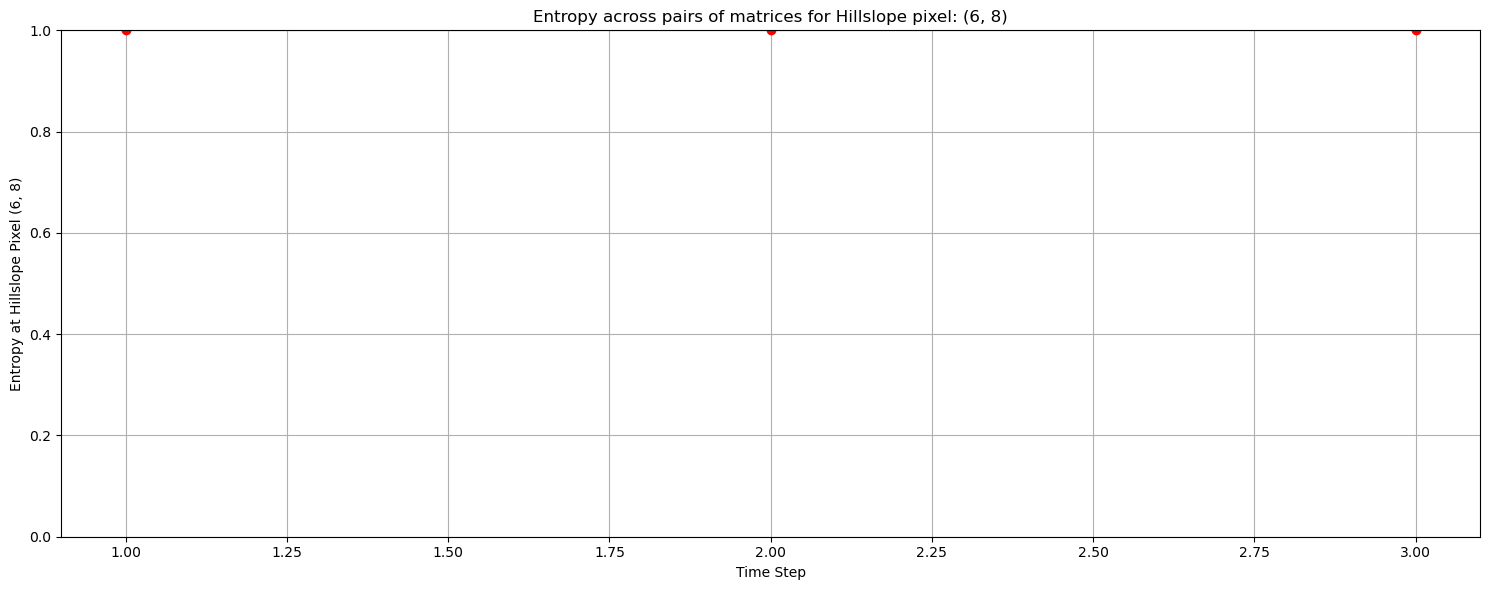

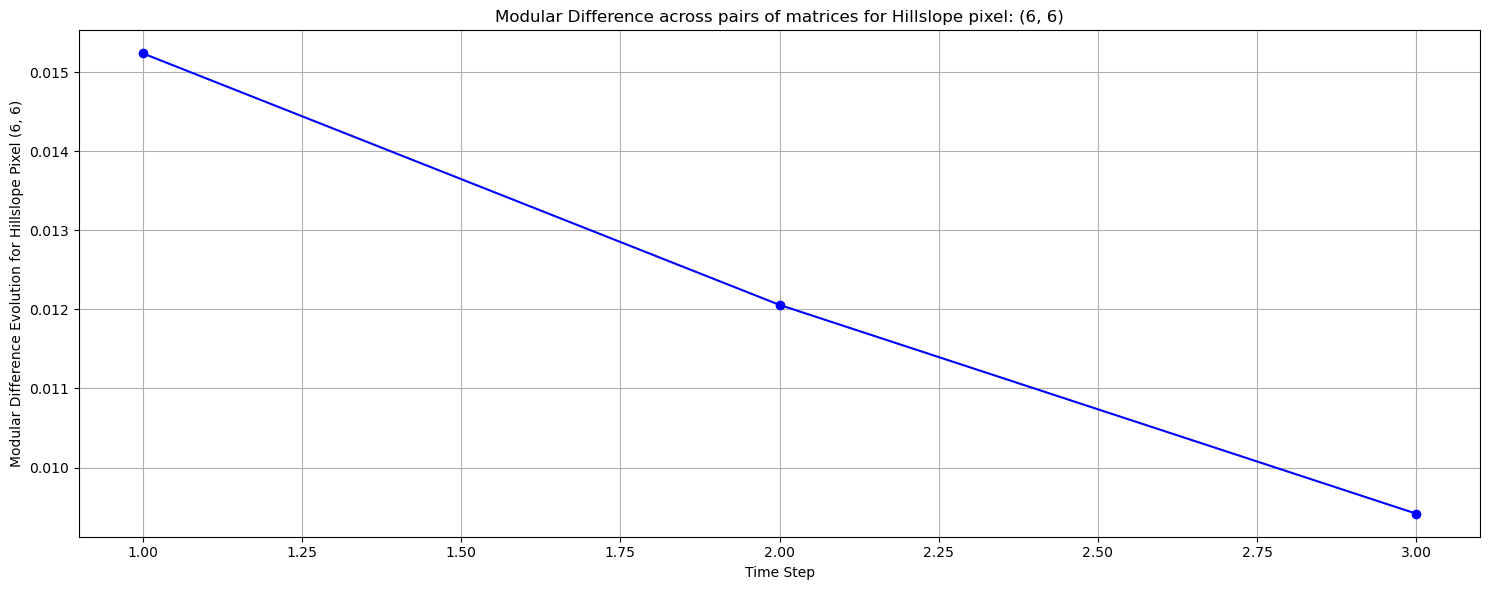

<Figure size 640x480 with 0 Axes>

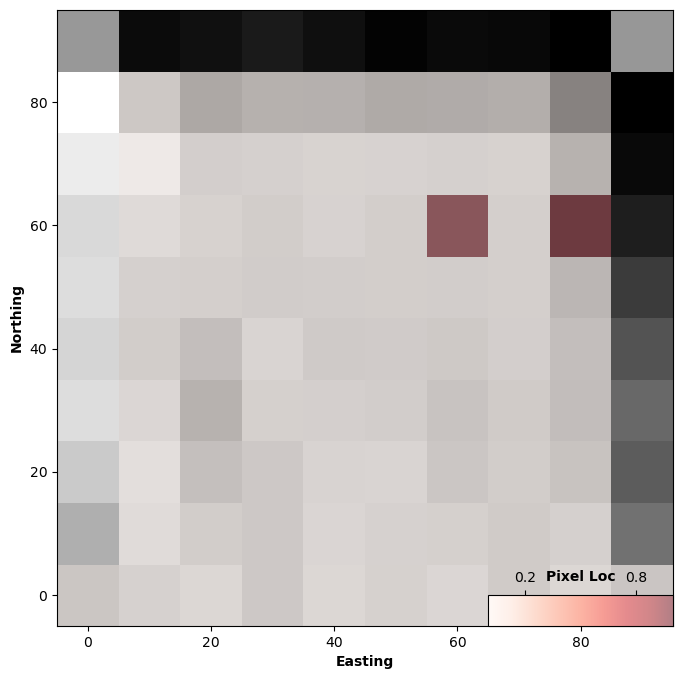

In [92]:
def pixel_entropy_across_experiments_mask(grid, matrices, mask, pixel_stream=None, pixel_hillslope=None):
    """
    Calculate the entropy based on the difference between matrices.

    Parameters:
    - grid: RasterModelGrid object
    - matrices: List of matrices (numpy arrays) to compare
    - k_global: Maximum modular difference (optional)
    - pixel: Tuple of (row, col) coordinates (optional)

    Returns:
    - entropies: The calculated Shannon entropies for each pair of experiments,
    with a local k derived from the absolute difference between the pair 
    of models
    """

    n = len(matrices)  # number of matrices
    
    # Calculate the modular difference for the streams
    R_stream = np.zeros(grid.shape)
    for i in range(R_stream.shape[0]):
        for j in range(R_stream.shape[1]):
            if mask[i, j]:
                R_stream[i, j] = max(abs(matrices[m][i, j] - matrices[(m + 1) % n][i, j]) for m in range(n))
    k_stream = np.max(R_stream)
    print("k_stream is: ", k_stream)
    
    max_k_pixel_stream = np.argmax(R_stream)
    max_abs_pixel_stream = np.unravel_index(max_k_pixel_stream, grid.shape)
    print(f"Pixel with highest absolute value: {max_abs_pixel_stream} -> Value: {R_stream[max_abs_pixel_stream]}")

    # Calculate the modular difference for the hillslopes
    R_hillslope = np.zeros(grid.shape)
    for i in range(R_hillslope.shape[0]):
        for j in range(R_hillslope.shape[1]):
            if not mask[i, j]:
                R_hillslope[i, j] = max(abs(matrices[m][i, j] - matrices[(m + 1) % n][i, j]) for m in range(n))
    k_hillslope = np.max(R_hillslope)
    print("k_hillslope is: ", k_hillslope)
    
    max_k_pixel_hlope = np.argmax(R_hillslope)
    max_abs_pixel_hlope = np.unravel_index(max_k_pixel_hlope, grid.shape)
    print(f"Pixel with highest absolute value: {max_abs_pixel_hlope} -> Value: {R_hillslope[max_abs_pixel_hlope]}")
    
    # Assign pixel for stream values
    if pixel_stream is None:
        row_stream, col_stream = max_abs_pixel_stream
    else:
        row_stream, col_stream = pixel_stream

    # Assign pixel for hillslope values
    if pixel_hillslope is None:
        row_hillslope, col_hillslope = max_abs_pixel_hlope
    else:
        row_hillslope, col_hillslope = pixel_hillslope
              
    entropies_stream = []
    entropies_hillslope = []
    
    mod_stream = []
    mod_hillslope = []

    for i in range(n - 1):
        j = i + 1  # Compare with the next matrix

        # Calculate probabilities for stream region
        diff_matrix_stream = abs(matrices[i] - matrices[j]) * mask
        k_local_stream = np.max(diff_matrix_stream)
        if k_local_stream > 0:
            p1_stream = diff_matrix_stream / (k_local_stream * 2)
            p1_stream = np.where(p1_stream == 0, 1e-10, p1_stream)  # Avoid log(0)
            p2_stream = 1 - p1_stream
            entropy_stream = -1 * (p1_stream * np.log2(p1_stream) + p2_stream * np.log2(p2_stream))
        else:
            entropy_stream = np.zeros(diff_matrix_stream.shape)
        entropies_stream.append(entropy_stream)
        mod_stream.append(diff_matrix_stream)

        # Calculate probabilities for hillslope region
        diff_matrix_hillslope = abs(matrices[i] - matrices[j]) * (~mask)
        k_local_hillslope = np.max(diff_matrix_hillslope)
        if k_local_hillslope > 0:
            p1_hillslope = diff_matrix_hillslope / (k_local_hillslope * 2)
            p1_hillslope = np.where(p1_hillslope == 0, 1e-10, p1_hillslope)  # Avoid log(0)
            p2_hillslope = 1 - p1_hillslope
            entropy_hillslope = -1 * (p1_hillslope * np.log2(p1_hillslope) + p2_hillslope * np.log2(p2_hillslope))
        else:
            entropy_hillslope = np.zeros(diff_matrix_hillslope.shape)
        entropies_hillslope.append(entropy_hillslope)
        mod_hillslope.append(diff_matrix_hillslope)

    entropies_stream_array = np.array(entropies_stream)
    entropies_hillslope_array = np.array(entropies_hillslope)
    
    mod_stream_array = np.array(mod_stream)
    mod_hillslope_array = np.array(mod_hillslope)

    # Extract pixel values from each matrix
    pixel_values_stream = entropies_stream_array[:, row_stream, col_stream]
    pixel_values_hillslope = entropies_hillslope_array[:, row_hillslope, col_hillslope]
    
    mod_pixel_values_stream = mod_stream_array[:, row_stream, col_stream]
    mod_pixel_values_hillslope = mod_hillslope_array[:, row_hillslope, col_hillslope]
    
    # Plotting stream pixel entropy
    plt.figure(figsize=(15, 6))
    plt.plot(range(1, len(entropies_stream_array) + 1), pixel_values_stream, marker='o', linestyle='-', color='b')
    #plt.xticks(np.arange(0, 271, 20))
    #plt.xticks(np.arange(0, len(entropies_stream_array) + 1, 1))  # Adjust the range as needed
    plt.xlabel('Time Step')
    plt.ylabel(f'Entropy at Stream Pixel ({row_stream}, {col_stream})')
    plt.ylim(0, 1)
    plt.title(f'Entropy across pairs of matrices for Stream pixel: ({row_stream}, {col_stream})')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plotting stream pixel module
    plt.figure(figsize=(15, 6))
    plt.plot(range(1, len(mod_stream_array) + 1), mod_pixel_values_stream, marker='o', linestyle='-', color='b')
    #plt.xticks(np.arange(0, 271, 20))
    #plt.xticks(np.arange(0, len(entropies_stream_array) + 1, 1))  # Adjust the range as needed
    plt.xlabel('Time Step')
    plt.ylabel(f'Modular Difference Evolution for Stream Pixel ({row_stream}, {col_stream})')
    #plt.ylim(0, 1)
    plt.title(f'Modular Difference across pairs of matrices for Stream pixel: ({row_stream}, {col_stream})')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plotting hillslope pixel entropy
    plt.figure(figsize=(15, 6))
    plt.plot(range(1, len(entropies_hillslope_array) + 1), pixel_values_hillslope, marker='o', linestyle='-', color='r')
    #plt.xticks(np.arange(0, 271, 20))
    #plt.xticks(np.arange(0, len(entropies_hillslope_array) + 1, 1))  # Adjust the range as needed
    plt.xlabel('Time Step')
    plt.ylabel(f'Entropy at Hillslope Pixel ({row_hillslope}, {col_hillslope})')
    plt.ylim(0, 1)
    plt.title(f'Entropy across pairs of matrices for Hillslope pixel: ({row_hillslope}, {col_hillslope})')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Plotting stream pixel module
    plt.figure(figsize=(15, 6))
    plt.plot(range(1, len(mod_hillslope_array) + 1), mod_pixel_values_hillslope, marker='o', linestyle='-', color='b')
    #plt.xticks(np.arange(0, 271, 20))
    #plt.xticks(np.arange(0, len(entropies_stream_array) + 1, 1))  # Adjust the range as needed
    plt.xlabel('Time Step')
    plt.ylabel(f'Modular Difference Evolution for Hillslope Pixel ({row_stream}, {col_stream})')
    #plt.ylim(0, 1)
    plt.title(f'Modular Difference across pairs of matrices for Hillslope pixel: ({row_stream}, {col_stream})')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Highlight the pixels in the grid

    grid.add_zeros('node', 'pixel_loc', clobber=True)
    
    # Convert the 2D pixel coordinate to 1D node index
    node_id_stream = grid.grid_coords_to_node_id(row_stream, col_stream)
    node_id_hillslope = grid.grid_coords_to_node_id(row_hillslope, col_hillslope)
    
    # Add 1 to pixel loc
    grid.at_node['pixel_loc'][node_id_stream] += 1
    grid.at_node['pixel_loc'][node_id_hillslope] += 1
    
    pixel_loc = grid.at_node['pixel_loc']

    # Replace all 0 values with NaN
    pixel_loc['pixel_loc' == 0] = np.nan
    
    # plt.figure()
    # imshow_grid(grid, 'pixel_loc', grid_units=("m", "m"), var_name="Pixel Loc", cmap="Blues")
    # plt.title("Pixel Loc")
    # plt.show()
    
    plt.figure()
    topo = np.ma.masked_equal(matrices[0], -9999)
    plt.figure(figsize=(10, 8))
    imshowhs_grid(grid, 
                  values=topo, 
                  plot_type='Drape1',
                  drape1='pixel_loc', cmap= 'Reds', 
                  alpha=0.5,
                  #color_for_closed='black', 
                  var_name='Pixel Loc', 
                  add_double_colorbar=True)
    plt.show()
    
    
    return entropies_stream_array, entropies_hillslope_array

entropies_stream_array, entropies_hillslope_array = pixel_entropy_across_experiments_mask (mg1, matrices, stream_mask)

For the buffered mask:

k_stream is:  0.0284257643397
Pixel with highest absolute value: (7, 4) -> Value: 0.02842576433967353
k_hillslope is:  0.0367097664061
Pixel with highest absolute value: (6, 8) -> Value: 0.03670976640614709


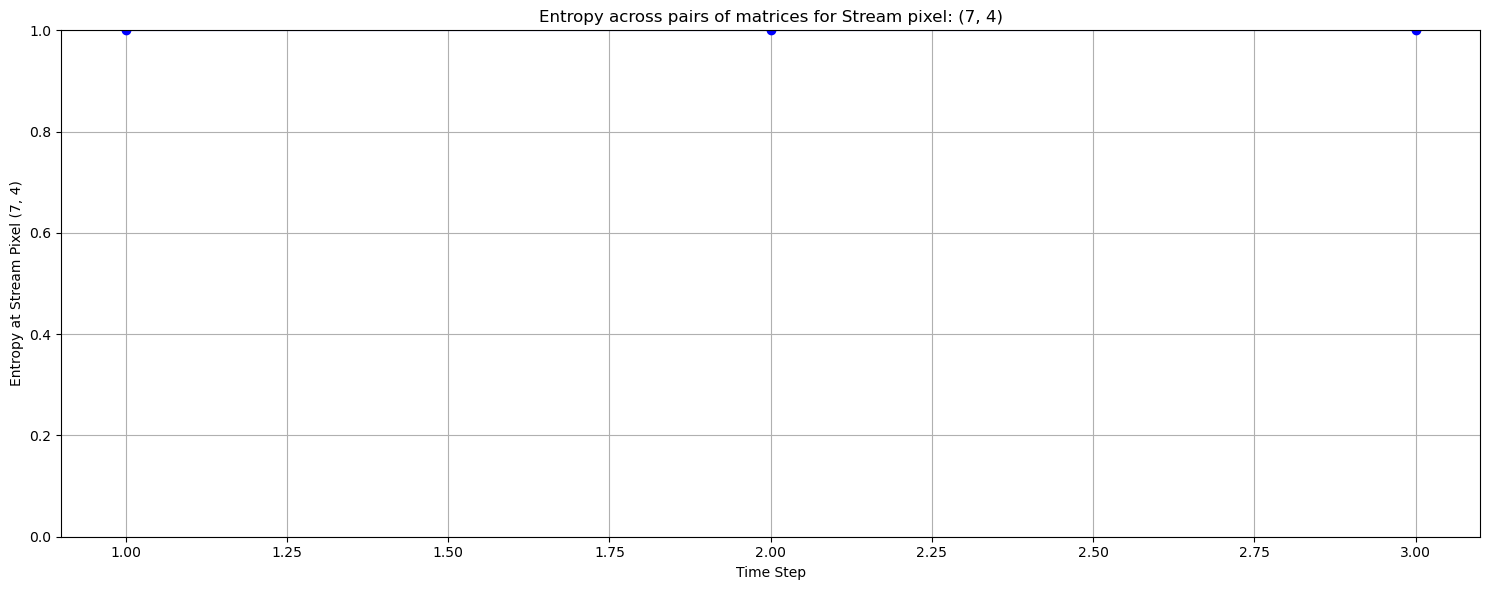

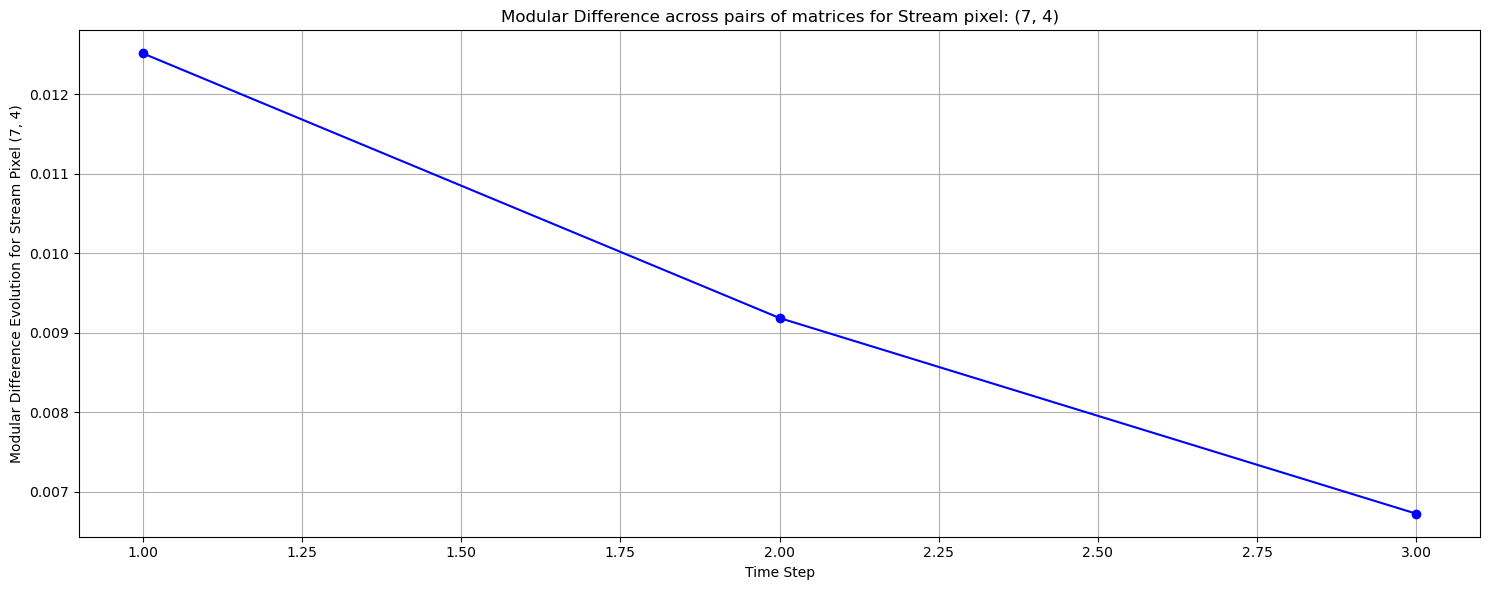

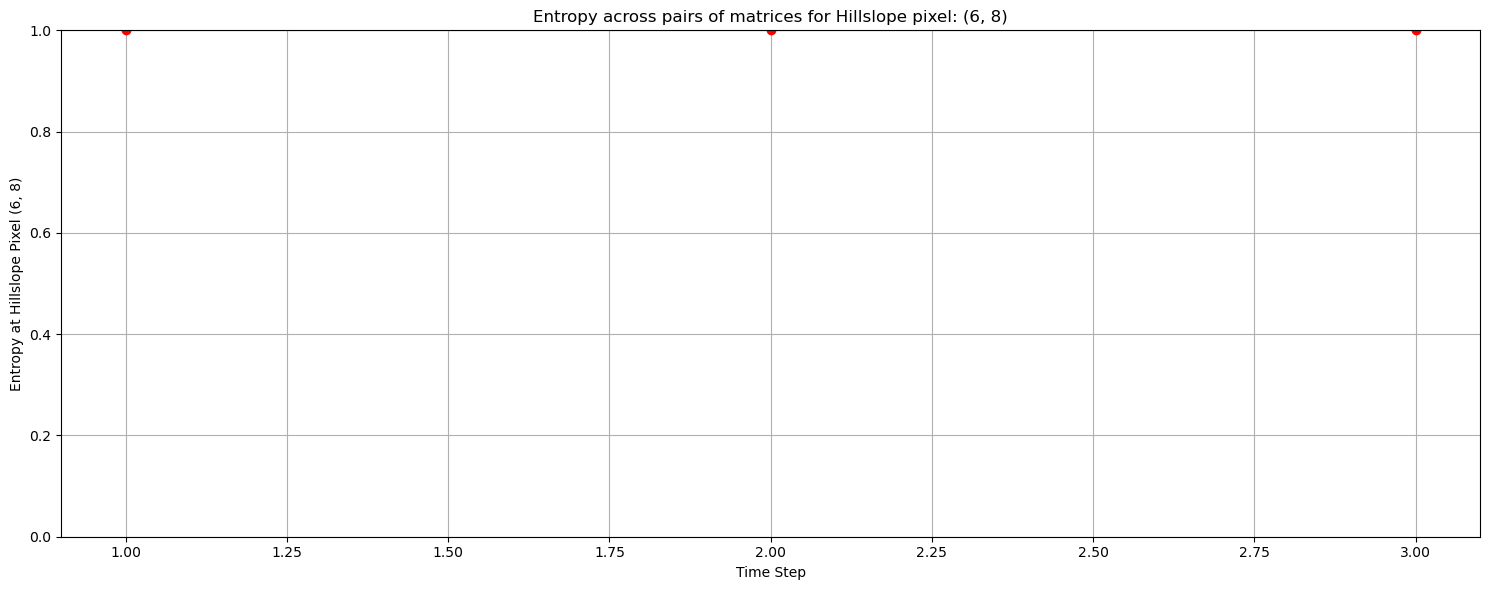

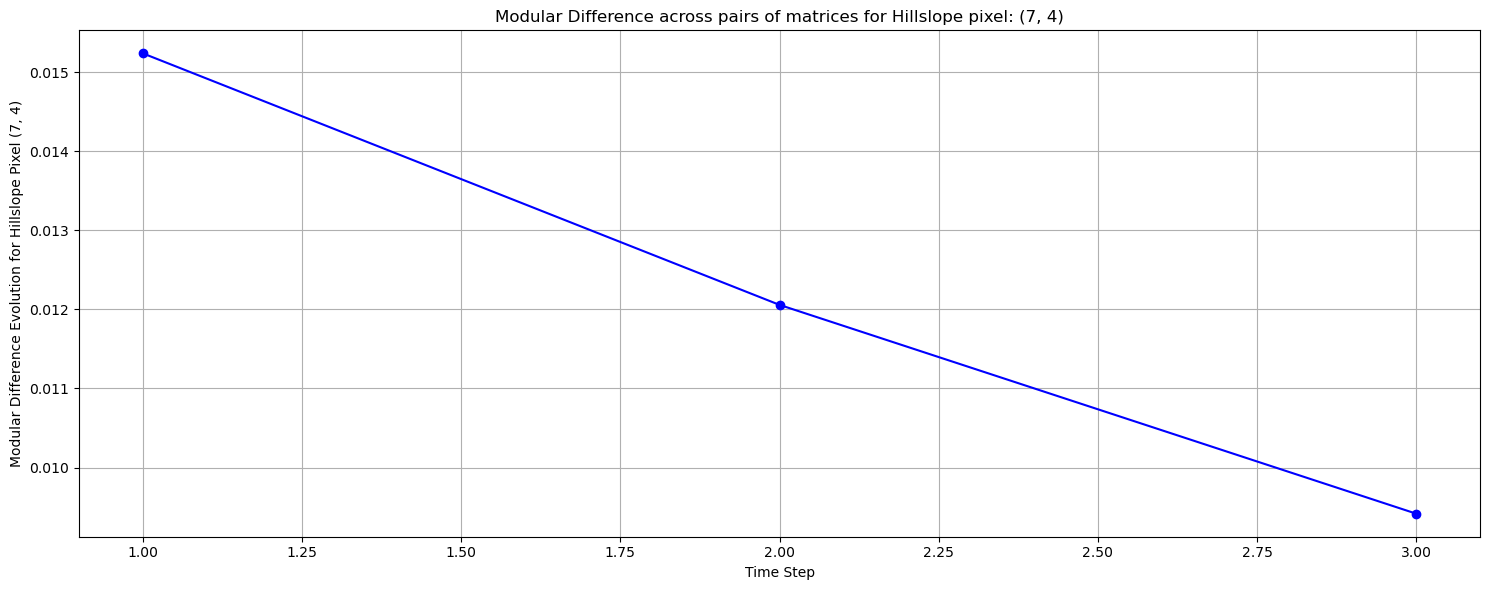

<Figure size 640x480 with 0 Axes>

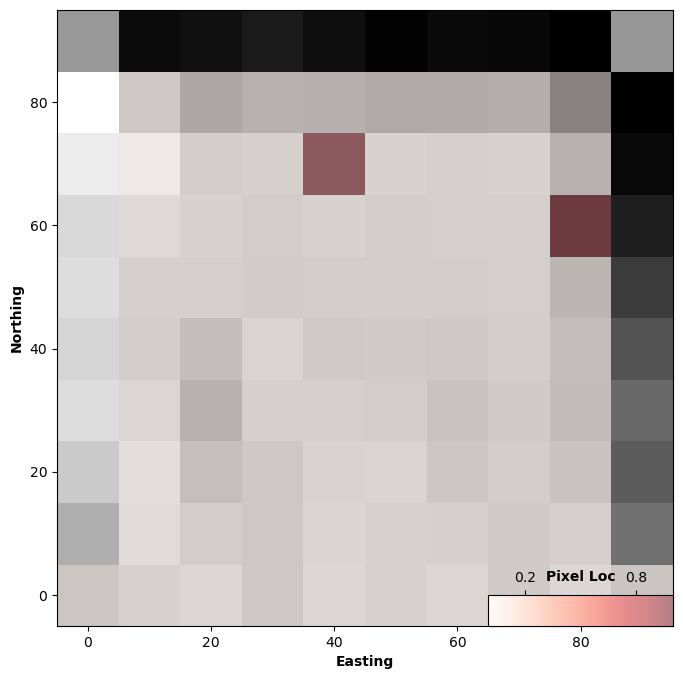

In [93]:
entropies_stream_array, entropies_hillslope_array = pixel_entropy_across_experiments_mask (mg1, matrices, stream_mask_buff)

And for the scaled buffered mask:

k_stream is:  0.0153591827779
Pixel with highest absolute value: (6, 6) -> Value: 0.015359182777856306
k_hillslope is:  0.0367097664061
Pixel with highest absolute value: (6, 8) -> Value: 0.03670976640614709


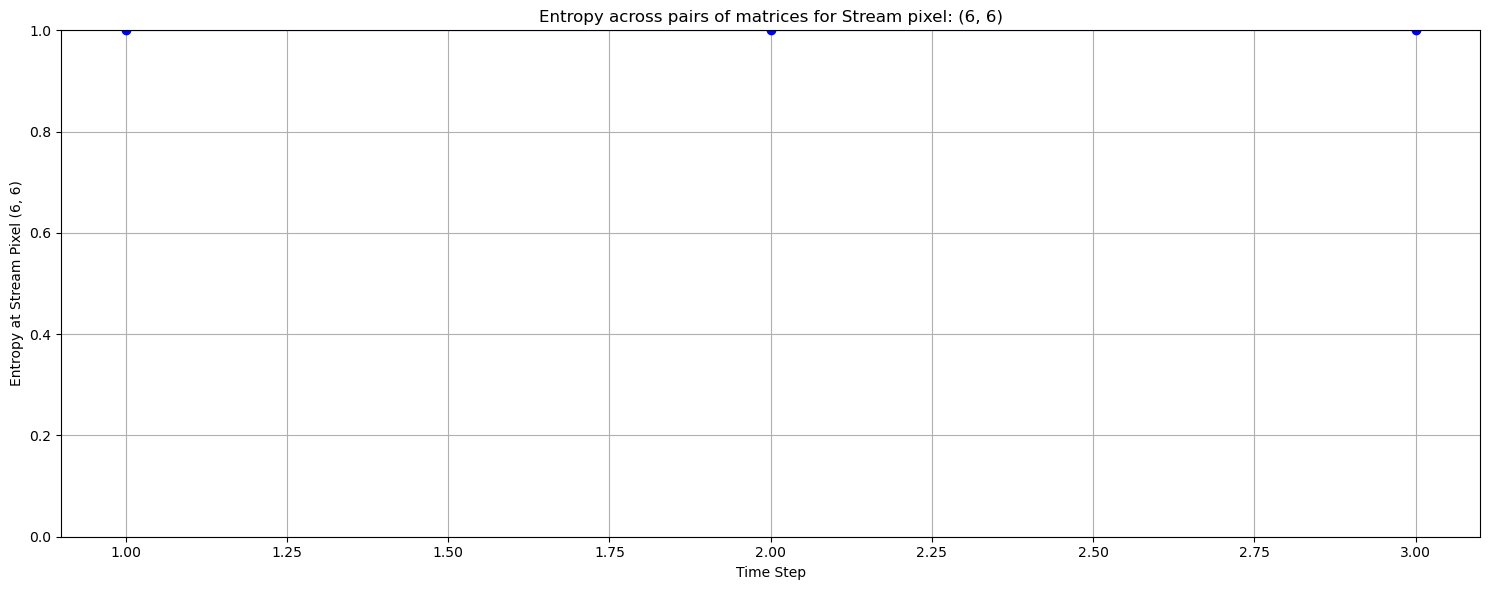

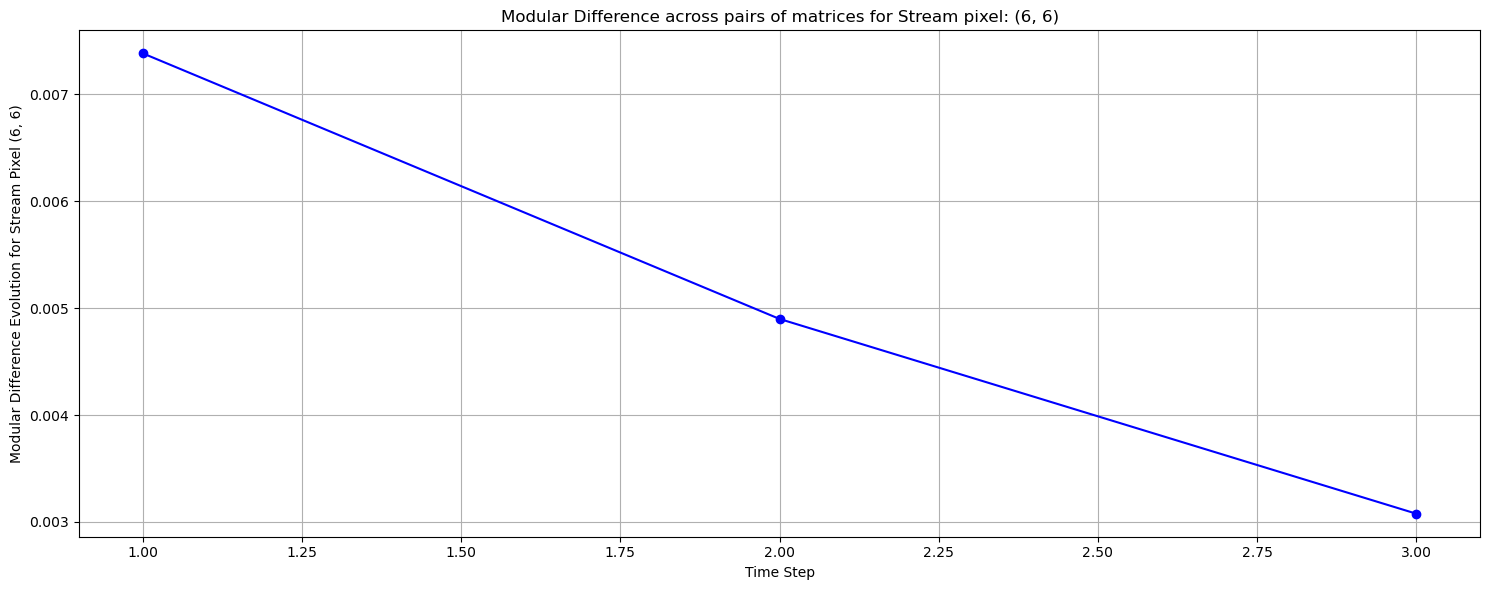

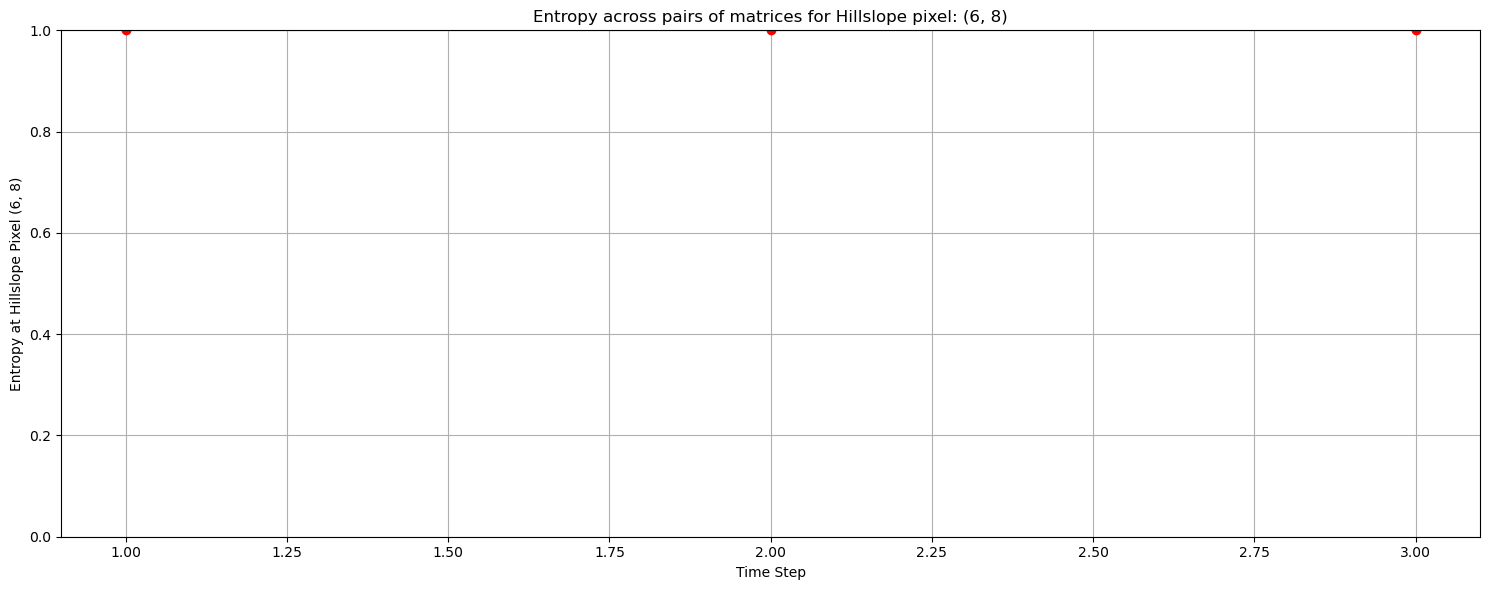

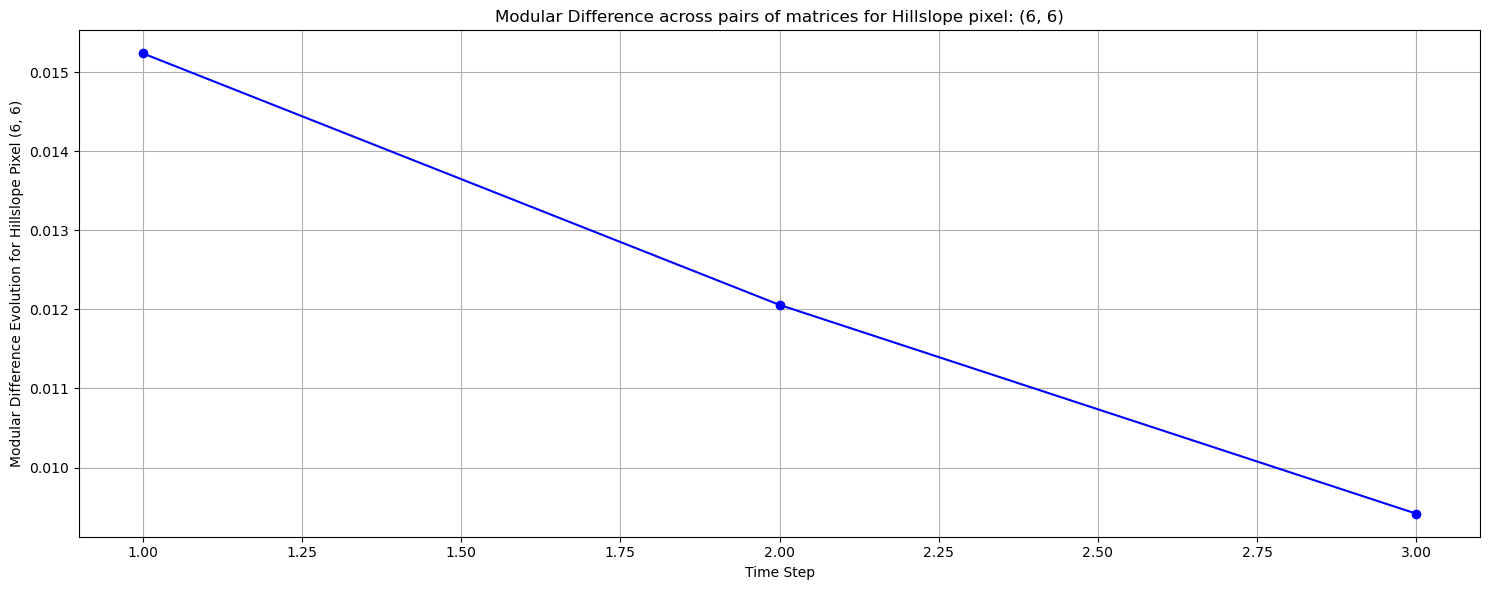

<Figure size 640x480 with 0 Axes>

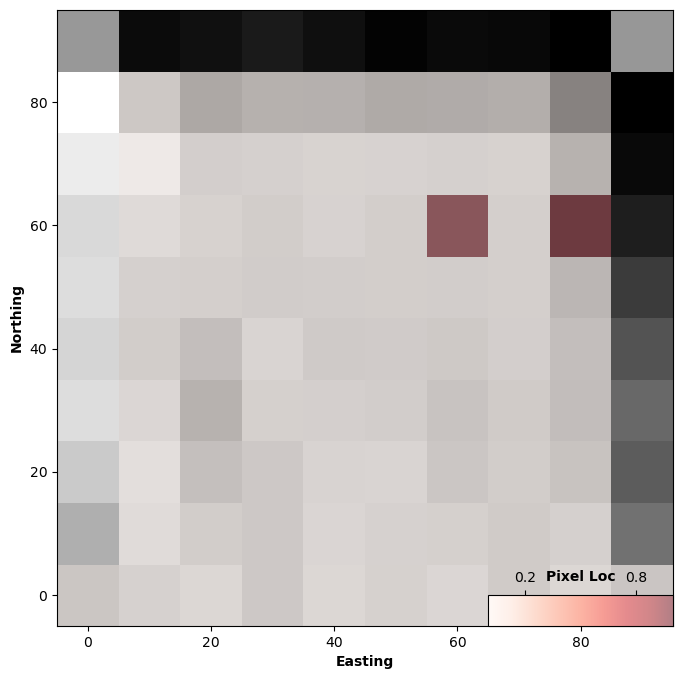

In [94]:
entropies_stream_array, entropies_hillslope_array = pixel_entropy_across_experiments_mask (mg1, matrices, stream_mask_scl_buff)

## Conclusion: ##

In the context of comparing landscape models, Shannon's Entropy, Moran's I and Geary's c offer insights into the spatial patterns and relationships within model outputs, they are calculated for the entire dataset, and provide a summary measure of spatial autocorrelation for the dataset as a whole. Outputs with similar Moran's I or Geary's c values suggest similar spatial arrangements of landscape features, indicating potential similarities in model behavior. Conversely, contrasting Moran's I or Geary's c values between model outputs may indicate significant differences in spatial patterns, highlighting areas where models diverge in their representations of landscape processes. 

Therefore, integrating these metrics into Landlab's comparison module will enable users to not only quantify differences in information content but also assess the spatial consistency and divergence among simulation results, facilitating comprehensive model evaluations and informed decision-making in landscape modeling studies.
